In [12]:
# pytorch requirements
import torch
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
from torch.autograd import Variable
from torch.utils.data import DataLoader
from tqdm import tqdm

# other requirements
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')
import numpy as np
import pandas as pd

import os
import random

# custom
#from utils import set_all_seeds, load_dataset
#from config import Config

#-----------------------------
%matplotlib inline

In [13]:
def gpu_info():
    print(torch.cuda.get_device_name(torch.cuda.current_device()))
    print(torch.cuda.device_count())
gpu_info()

Tesla K80
1


In [14]:
# loading the dataset------------------------------------------
def load_dataset(batch_size):
    # loading the MNIST dataset
    train_set = datasets.MNIST(root = 'data', train = True, download = True, transform = transforms.ToTensor())
    test_set = datasets.MNIST(root = 'data', train = False, download = True, transform = transforms.ToTensor())

    # Setting up the dataloaders
    train_dataloader = DataLoader(dataset = train_set, batch_size = batch_size, shuffle = True)
    test_dataloader = DataLoader(dataset = test_set, batch_size = batch_size, shuffle = True)
    
    return train_dataloader, test_dataloader

    
# setting random seeds-----------------------------------------
def set_all_seeds(seed):
    os.environ["PL_GLOBAL_SEED"] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

In [15]:
small1 = torch.tensor([1e-10])
small2 = torch.tensor([1e-10])

In [41]:
import math
import torch
import torch.nn as nn
import torch.utils
import torch.utils.data
from torchvision import datasets, transforms
from torch.autograd import Variable
import matplotlib.pyplot as plt 


"""implementation of the Variational Recurrent
Neural Network (VRNN) from https://arxiv.org/abs/1506.02216
using unimodal isotropic gaussian distributions for 
inference, prior, and generating models."""


class VRNN(nn.Module):
	def __init__(self, x_dim, h_dim, z_dim, n_layers, bias=False):
		super(VRNN, self).__init__()

		self.x_dim = x_dim
		self.h_dim = h_dim
		self.z_dim = z_dim
		self.n_layers = n_layers

		#feature-extracting transformations
		self.phi_x = nn.Sequential(
			nn.Linear(x_dim, h_dim),
			nn.ReLU(),
			nn.Linear(h_dim, h_dim),
			nn.ReLU())
		self.phi_z = nn.Sequential(
			nn.Linear(z_dim, h_dim),
			nn.ReLU())

		#encoder
		self.enc = nn.Sequential(
			nn.Linear(h_dim + h_dim, h_dim),
			nn.ReLU(),
			nn.Linear(h_dim, h_dim),
			nn.ReLU())
		self.enc_mean = nn.Linear(h_dim, z_dim)
		self.enc_std = nn.Sequential(
			nn.Linear(h_dim, z_dim),
			nn.Softplus())

		#prior
		self.prior = nn.Sequential(
			nn.Linear(h_dim, h_dim),
			nn.ReLU())
		self.prior_mean = nn.Linear(h_dim, z_dim)
		self.prior_std = nn.Sequential(
			nn.Linear(h_dim, z_dim),
			nn.Softplus())

		#decoder
		self.dec = nn.Sequential(
			nn.Linear(h_dim + h_dim, h_dim),
			nn.ReLU(),
			nn.Linear(h_dim, h_dim),
			nn.ReLU())
		self.dec_std = nn.Sequential(
			nn.Linear(h_dim, x_dim),
			nn.Softplus())
		#self.dec_mean = nn.Linear(h_dim, x_dim)
		self.dec_mean = nn.Sequential(
			nn.Linear(h_dim, x_dim),
			nn.Sigmoid())

		#recurrence
		self.rnn = nn.GRU(h_dim + h_dim, h_dim, n_layers, bias)


	def forward(self, x):

		all_enc_mean, all_enc_std = [], []
		all_dec_mean, all_dec_std = [], []
		kld_loss = 0
		nll_loss = 0

		h = Variable(torch.zeros(self.n_layers, x.size(1), self.h_dim))
		for t in range(x.size(0)):
			
			phi_x_t = self.phi_x(x[t])

			#encoder
			enc_t = self.enc(torch.cat([phi_x_t, h[-1]], 1))
			enc_mean_t = self.enc_mean(enc_t)
			enc_std_t = self.enc_std(enc_t)

			#prior
			prior_t = self.prior(h[-1])
			prior_mean_t = self.prior_mean(prior_t)
			prior_std_t = self.prior_std(prior_t)

			#sampling and reparameterization
			z_t = self._reparameterized_sample(enc_mean_t, enc_std_t)
			phi_z_t = self.phi_z(z_t)

			#decoder
			dec_t = self.dec(torch.cat([phi_z_t, h[-1]], 1))
			dec_mean_t = self.dec_mean(dec_t)
			dec_std_t = self.dec_std(dec_t)

			#recurrence
			_, h = self.rnn(torch.cat([phi_x_t, phi_z_t], 1).unsqueeze(0), h)

			#computing losses
			kld_loss += self._kld_gauss(enc_mean_t, enc_std_t, prior_mean_t, prior_std_t)
			#kld_loss += self.KLD_loss(enc_mean_t, enc_std_t, prior_mean_t, prior_std_t)
			#nll_loss += self._nll_gauss(dec_mean_t, dec_std_t, x[t])
			nll_loss += self._nll_bernoulli(dec_mean_t, x[t])

			all_enc_std.append(enc_std_t)
			all_enc_mean.append(enc_mean_t)
			all_dec_mean.append(dec_mean_t)
			all_dec_std.append(dec_std_t)

		return kld_loss, nll_loss, \
			(all_enc_mean, all_enc_std), \
			(all_dec_mean, all_dec_std)


	def sample(self, seq_len):

		sample = torch.zeros(seq_len, self.x_dim)

		h = Variable(torch.zeros(self.n_layers, 1, self.h_dim))
		for t in range(seq_len):

			#prior
			prior_t = self.prior(h[-1])
			prior_mean_t = self.prior_mean(prior_t)
			prior_std_t = self.prior_std(prior_t)

			#sampling and reparameterization
			z_t = self._reparameterized_sample(prior_mean_t, prior_std_t)
			phi_z_t = self.phi_z(z_t)
			
			#decoder
			dec_t = self.dec(torch.cat([phi_z_t, h[-1]], 1))
			dec_mean_t = self.dec_mean(dec_t)
			#dec_std_t = self.dec_std(dec_t)

			phi_x_t = self.phi_x(dec_mean_t)

			#recurrence
			_, h = self.rnn(torch.cat([phi_x_t, phi_z_t], 1).unsqueeze(0), h)

			sample[t] = dec_mean_t.data
	
		return sample


	def reset_parameters(self, stdv=1e-1):
		for weight in self.parameters():
			weight.data.normal_(0, stdv)


	def _init_weights(self, stdv):
		pass


	def _reparameterized_sample(self, mean, std):
		"""using std to sample"""
		eps = torch.FloatTensor(std.size()).normal_()
		eps = Variable(eps)
		return eps.mul(std).add_(mean)


	def _kld_gauss(self, mean_1, std_1, mean_2, std_2):
		"""Using std to compute KLD"""

		kld_element =  (2 * torch.log(torch.max(std_2,small1)) - 2 * torch.log(torch.max(std_1,small1)) + 
			(std_1.pow(2) + (mean_1 - mean_2).pow(2)) /
			(std_2.pow(2)+1e-10) - 1)
		return	0.5 * torch.sum(kld_element)


	def _nll_bernoulli(self, theta, x):
		return - torch.sum(x*torch.log(torch.max(theta,small2)) + (1-x)*torch.log(torch.max(1-theta,small2)))


	#def KLD_loss(self, mean_1, std_1, mean_2, std_2):
		#ret = -0.5 * torch.sum(std_1 - std_2 - torch.div(std_1.exp() + (mean_1 - mean_2).pow(2), std_2.exp()+1e-10))
		#return ret

	def _nll_gauss(self, mean, std, x):
		pass
    
	# for reconstructing the output from the given input by samping latent vector from posterior distribution
	def reconstruction_from_posterior(self, x):
        
		timesteps = x.size(1)  # timesteps = 28  (x is of shape = (28, 28))
		h = torch.zeros([self.n_layers, 1, self.h_dim]) # no_of_layers x batch_size x h_dim
        
		seq_len = x.size(1)
		sample_post = torch.zeros(seq_len, self.x_dim)
        
		for t in range(timesteps):
            
			# feature extraction for x_t
			phi_x_t = self.phi_x(x[t].unsqueeze(0))  # x is (28,28), x[t] is (28,), x[t].unsqueeze(0) is (1,28)
            
			# encoder
			encoder_t = self.enc(torch.cat([phi_x_t, h[-1]], 1))
			encoder_mean_t = self.enc_mean(encoder_t)
			encoder_var_t = self.enc_std(encoder_t)
            
			# reparameterization
			z_t = self._reparameterized_sample(encoder_mean_t, encoder_var_t)
            
			# feature extraction for z_t
			phi_z_t = self.phi_z(z_t)
            
			# decoder
			decoder_t = self.dec(torch.cat([phi_z_t, h[-1]], 1))
			decoder_mean_t = self.dec_mean(decoder_t)
			decoder_var_t = self.dec_std(decoder_t)
            
			# recurrence
			h = self.recurrence(phi_x_t, phi_z_t, h)
            
			sample_post[t] = decoder_mean_t.data
            
		return sample_post

Train Epoch: 1 [0/60000 (0%)]	 KLD Loss: 7.673828 	 NLL Loss: 544.917480


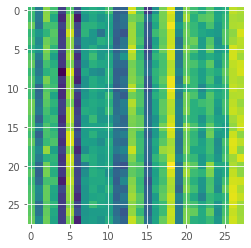

Train Epoch: 1 [2800/60000 (21%)]	 KLD Loss: 3.698221 	 NLL Loss: 189.052612


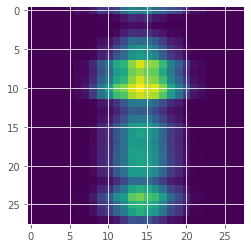

Train Epoch: 1 [5600/60000 (43%)]	 KLD Loss: 2.389929 	 NLL Loss: 134.096115


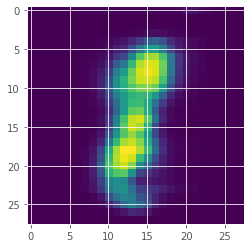

Train Epoch: 1 [8400/60000 (64%)]	 KLD Loss: 2.371349 	 NLL Loss: 102.904327


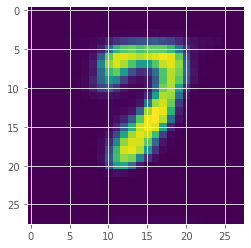

Train Epoch: 1 [11200/60000 (85%)]	 KLD Loss: 2.348011 	 NLL Loss: 99.264984


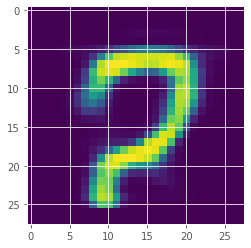

====> Epoch: 1 Average loss: 155.6185
====> Test set loss: KLD Loss = 2.1965, NLL Loss = 92.7958 
Saved model to saves/vrnn_state_dict_1.pth
Train Epoch: 2 [0/60000 (0%)]	 KLD Loss: 2.304492 	 NLL Loss: 96.642548


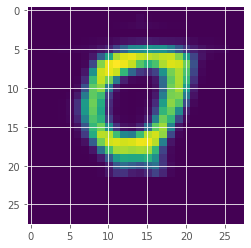

Train Epoch: 2 [2800/60000 (21%)]	 KLD Loss: 2.075652 	 NLL Loss: 88.463554


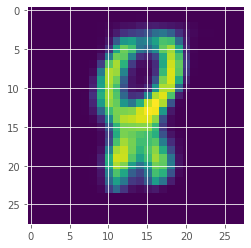

Train Epoch: 2 [5600/60000 (43%)]	 KLD Loss: 2.067077 	 NLL Loss: 86.739708


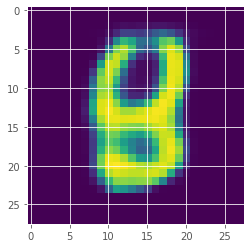

Train Epoch: 2 [8400/60000 (64%)]	 KLD Loss: 2.082382 	 NLL Loss: 85.017105


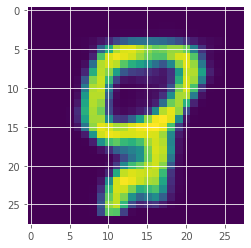

Train Epoch: 2 [11200/60000 (85%)]	 KLD Loss: 2.317725 	 NLL Loss: 85.566574


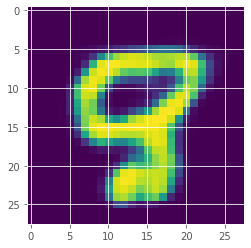

====> Epoch: 2 Average loss: 91.9601
====> Test set loss: KLD Loss = 2.2700, NLL Loss = 85.1215 
Train Epoch: 3 [0/60000 (0%)]	 KLD Loss: 2.233965 	 NLL Loss: 82.077591


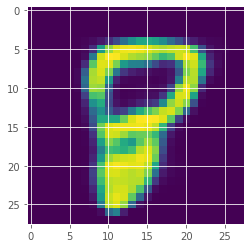

Train Epoch: 3 [2800/60000 (21%)]	 KLD Loss: 2.727878 	 NLL Loss: 84.978889


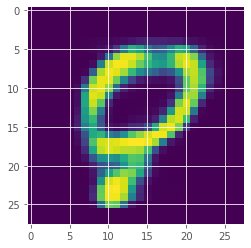

Train Epoch: 3 [5600/60000 (43%)]	 KLD Loss: 2.894910 	 NLL Loss: 85.964317


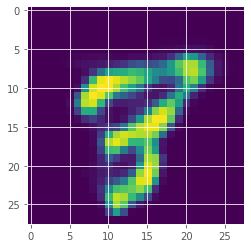

Train Epoch: 3 [8400/60000 (64%)]	 KLD Loss: 2.486007 	 NLL Loss: 81.148544


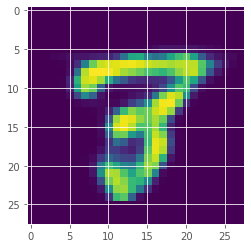

Train Epoch: 3 [11200/60000 (85%)]	 KLD Loss: 2.611170 	 NLL Loss: 80.734848


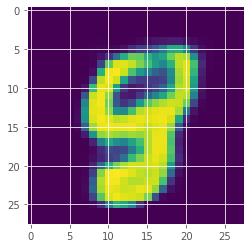

====> Epoch: 3 Average loss: 86.6631
====> Test set loss: KLD Loss = 2.6726, NLL Loss = 81.4622 
Train Epoch: 4 [0/60000 (0%)]	 KLD Loss: 2.805505 	 NLL Loss: 83.011154


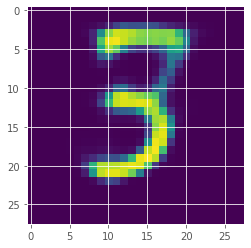

Train Epoch: 4 [2800/60000 (21%)]	 KLD Loss: 2.590749 	 NLL Loss: 79.091759


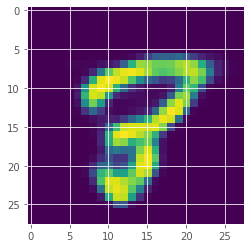

Train Epoch: 4 [5600/60000 (43%)]	 KLD Loss: 2.868816 	 NLL Loss: 85.882706


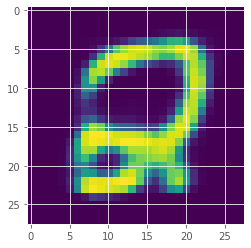

Train Epoch: 4 [8400/60000 (64%)]	 KLD Loss: 2.900765 	 NLL Loss: 79.873474


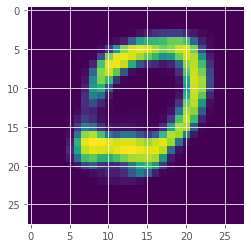

Train Epoch: 4 [11200/60000 (85%)]	 KLD Loss: 2.877148 	 NLL Loss: 82.054138


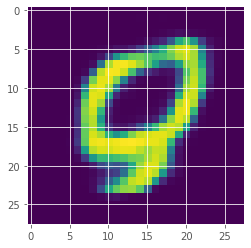

====> Epoch: 4 Average loss: 83.5891
====> Test set loss: KLD Loss = 2.8200, NLL Loss = 78.9622 
Train Epoch: 5 [0/60000 (0%)]	 KLD Loss: 2.866263 	 NLL Loss: 80.111305


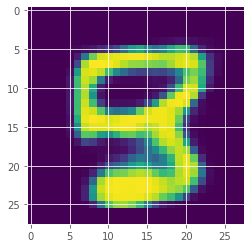

Train Epoch: 5 [2800/60000 (21%)]	 KLD Loss: 2.995614 	 NLL Loss: 76.441208


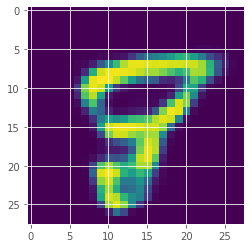

Train Epoch: 5 [5600/60000 (43%)]	 KLD Loss: 3.038651 	 NLL Loss: 78.533630


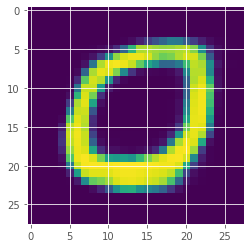

Train Epoch: 5 [8400/60000 (64%)]	 KLD Loss: 3.097087 	 NLL Loss: 79.590012


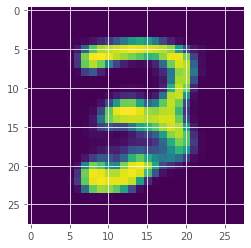

Train Epoch: 5 [11200/60000 (85%)]	 KLD Loss: 2.871143 	 NLL Loss: 78.603432


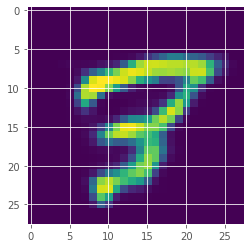

====> Epoch: 5 Average loss: 81.6377
====> Test set loss: KLD Loss = 3.0151, NLL Loss = 77.2829 
Train Epoch: 6 [0/60000 (0%)]	 KLD Loss: 2.994275 	 NLL Loss: 77.250763


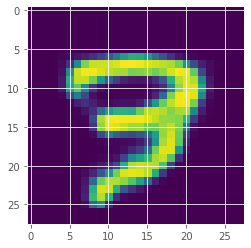

Train Epoch: 6 [2800/60000 (21%)]	 KLD Loss: 2.992330 	 NLL Loss: 76.958862


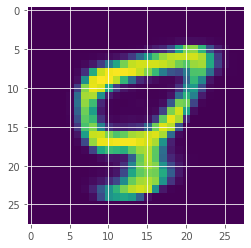

Train Epoch: 6 [5600/60000 (43%)]	 KLD Loss: 3.019629 	 NLL Loss: 78.834099


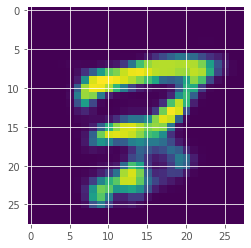

Train Epoch: 6 [8400/60000 (64%)]	 KLD Loss: 2.897484 	 NLL Loss: 77.996872


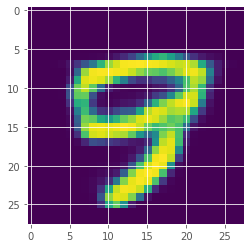

Train Epoch: 6 [11200/60000 (85%)]	 KLD Loss: 3.054308 	 NLL Loss: 78.229813


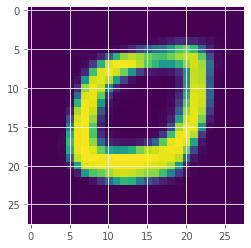

====> Epoch: 6 Average loss: 80.3714
====> Test set loss: KLD Loss = 3.0416, NLL Loss = 76.1096 
Train Epoch: 7 [0/60000 (0%)]	 KLD Loss: 2.926386 	 NLL Loss: 75.031090


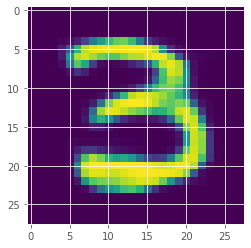

Train Epoch: 7 [2800/60000 (21%)]	 KLD Loss: 3.091290 	 NLL Loss: 76.162727


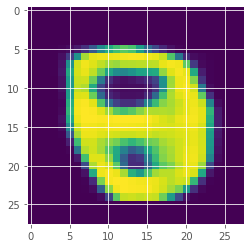

Train Epoch: 7 [5600/60000 (43%)]	 KLD Loss: 3.004100 	 NLL Loss: 76.066864


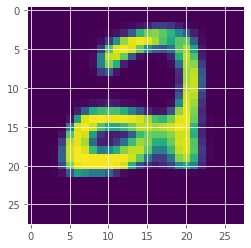

Train Epoch: 7 [8400/60000 (64%)]	 KLD Loss: 3.190225 	 NLL Loss: 77.046059


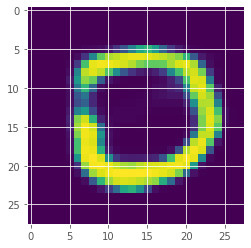

Train Epoch: 7 [11200/60000 (85%)]	 KLD Loss: 3.109094 	 NLL Loss: 77.583954


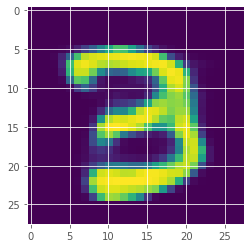

====> Epoch: 7 Average loss: 79.3845
====> Test set loss: KLD Loss = 2.9608, NLL Loss = 75.3035 
Train Epoch: 8 [0/60000 (0%)]	 KLD Loss: 2.953041 	 NLL Loss: 76.175591


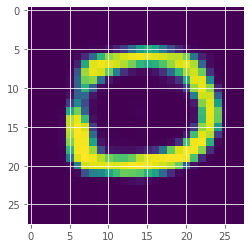

Train Epoch: 8 [2800/60000 (21%)]	 KLD Loss: 3.035704 	 NLL Loss: 76.945282


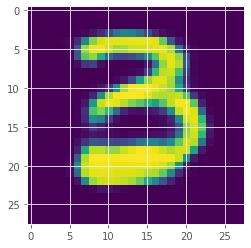

Train Epoch: 8 [5600/60000 (43%)]	 KLD Loss: 2.918560 	 NLL Loss: 74.490990


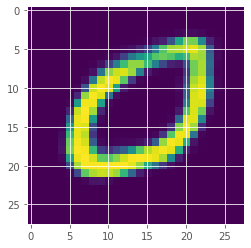

Train Epoch: 8 [8400/60000 (64%)]	 KLD Loss: 3.181778 	 NLL Loss: 78.740150


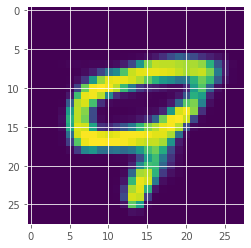

Train Epoch: 8 [11200/60000 (85%)]	 KLD Loss: 3.017563 	 NLL Loss: 75.528915


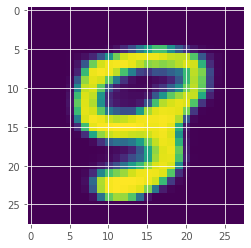

====> Epoch: 8 Average loss: 78.6893
====> Test set loss: KLD Loss = 3.0222, NLL Loss = 74.4155 
Train Epoch: 9 [0/60000 (0%)]	 KLD Loss: 3.042746 	 NLL Loss: 73.682541


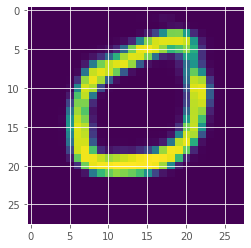

Train Epoch: 9 [2800/60000 (21%)]	 KLD Loss: 3.080046 	 NLL Loss: 74.223343


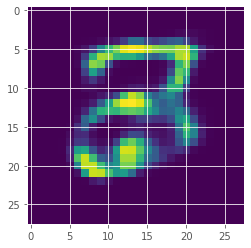

Train Epoch: 9 [5600/60000 (43%)]	 KLD Loss: 2.879273 	 NLL Loss: 71.432228


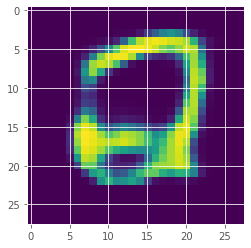

Train Epoch: 9 [8400/60000 (64%)]	 KLD Loss: 3.206331 	 NLL Loss: 71.221489


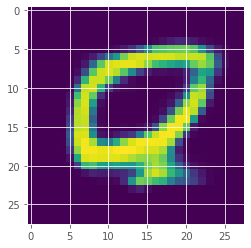

Train Epoch: 9 [11200/60000 (85%)]	 KLD Loss: 3.093150 	 NLL Loss: 75.362549


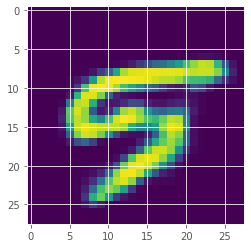

====> Epoch: 9 Average loss: 78.2101
====> Test set loss: KLD Loss = 3.1278, NLL Loss = 73.8663 
Train Epoch: 10 [0/60000 (0%)]	 KLD Loss: 2.985077 	 NLL Loss: 74.870750


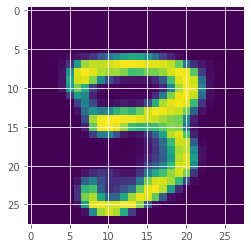

Train Epoch: 10 [2800/60000 (21%)]	 KLD Loss: 3.121446 	 NLL Loss: 74.374931


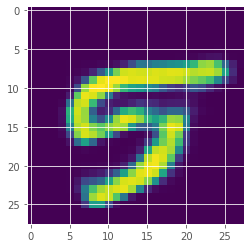

Train Epoch: 10 [5600/60000 (43%)]	 KLD Loss: 3.217241 	 NLL Loss: 77.141571


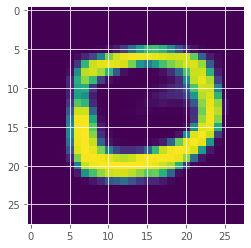

Train Epoch: 10 [8400/60000 (64%)]	 KLD Loss: 3.234821 	 NLL Loss: 72.348602


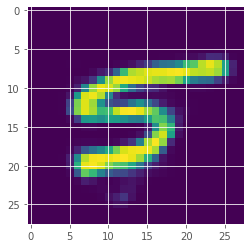

Train Epoch: 10 [11200/60000 (85%)]	 KLD Loss: 3.299712 	 NLL Loss: 72.703171


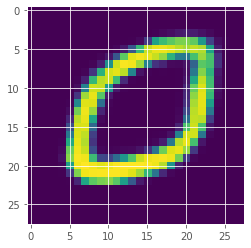

====> Epoch: 10 Average loss: 77.6621
====> Test set loss: KLD Loss = 3.5498, NLL Loss = 74.0579 
Train Epoch: 11 [0/60000 (0%)]	 KLD Loss: 3.624906 	 NLL Loss: 75.335846


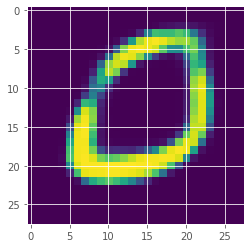

Train Epoch: 11 [2800/60000 (21%)]	 KLD Loss: 3.292402 	 NLL Loss: 76.385132


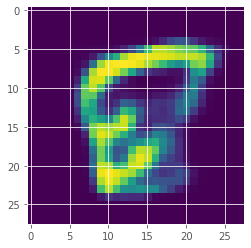

Train Epoch: 11 [5600/60000 (43%)]	 KLD Loss: 3.301389 	 NLL Loss: 73.629425


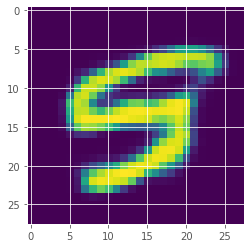

Train Epoch: 11 [8400/60000 (64%)]	 KLD Loss: 2.998682 	 NLL Loss: 75.036278


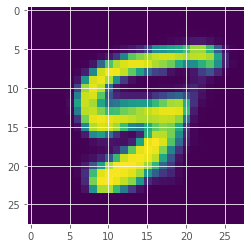

Train Epoch: 11 [11200/60000 (85%)]	 KLD Loss: 3.405956 	 NLL Loss: 75.565063


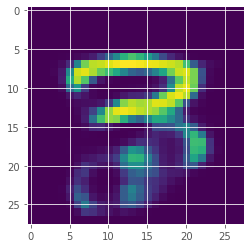

====> Epoch: 11 Average loss: 77.3002
====> Test set loss: KLD Loss = 3.1364, NLL Loss = 73.3111 
Saved model to saves/vrnn_state_dict_11.pth
Train Epoch: 12 [0/60000 (0%)]	 KLD Loss: 3.172023 	 NLL Loss: 73.847961


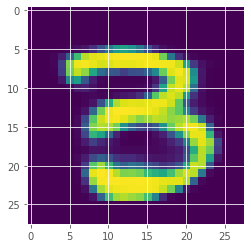

Train Epoch: 12 [2800/60000 (21%)]	 KLD Loss: 3.032497 	 NLL Loss: 72.409767


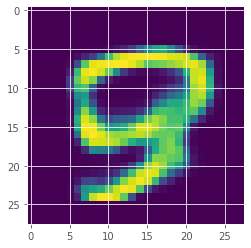

Train Epoch: 12 [5600/60000 (43%)]	 KLD Loss: 3.040004 	 NLL Loss: 70.990082


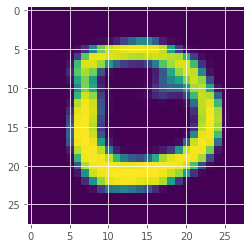

Train Epoch: 12 [8400/60000 (64%)]	 KLD Loss: 3.134183 	 NLL Loss: 71.466805


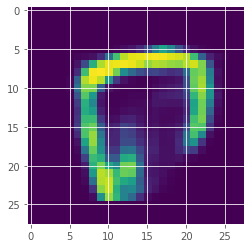

Train Epoch: 12 [11200/60000 (85%)]	 KLD Loss: 3.155463 	 NLL Loss: 71.475739


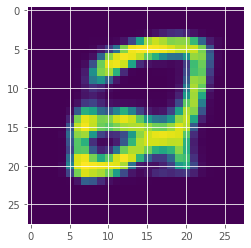

====> Epoch: 12 Average loss: 76.9336
====> Test set loss: KLD Loss = 3.1833, NLL Loss = 72.9791 
Train Epoch: 13 [0/60000 (0%)]	 KLD Loss: 3.445807 	 NLL Loss: 75.079872


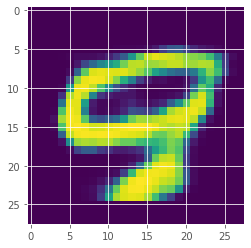

Train Epoch: 13 [2800/60000 (21%)]	 KLD Loss: 3.372104 	 NLL Loss: 72.142151


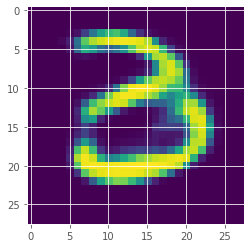

Train Epoch: 13 [5600/60000 (43%)]	 KLD Loss: 3.277047 	 NLL Loss: 72.500572


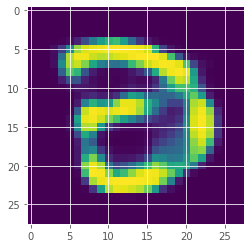

Train Epoch: 13 [8400/60000 (64%)]	 KLD Loss: 3.659610 	 NLL Loss: 73.088303


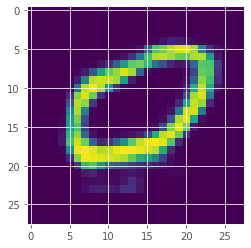

Train Epoch: 13 [11200/60000 (85%)]	 KLD Loss: 3.266950 	 NLL Loss: 70.286041


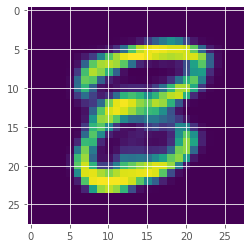

====> Epoch: 13 Average loss: 76.6120
====> Test set loss: KLD Loss = 3.3096, NLL Loss = 72.4326 
Train Epoch: 14 [0/60000 (0%)]	 KLD Loss: 3.398762 	 NLL Loss: 73.395409


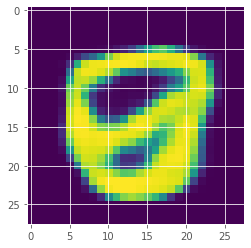

Train Epoch: 14 [2800/60000 (21%)]	 KLD Loss: 3.163683 	 NLL Loss: 71.046837


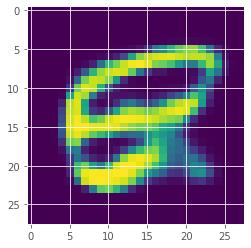

Train Epoch: 14 [5600/60000 (43%)]	 KLD Loss: 3.407096 	 NLL Loss: 74.404716


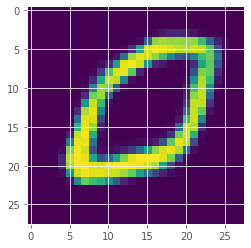

Train Epoch: 14 [8400/60000 (64%)]	 KLD Loss: 3.408457 	 NLL Loss: 76.088402


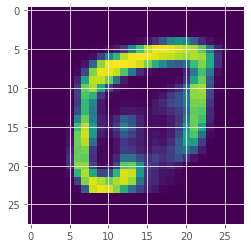

Train Epoch: 14 [11200/60000 (85%)]	 KLD Loss: 3.464009 	 NLL Loss: 73.711075


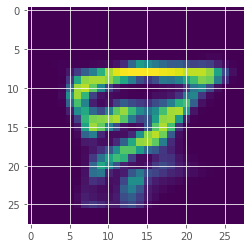

====> Epoch: 14 Average loss: 76.2954
====> Test set loss: KLD Loss = 3.1419, NLL Loss = 72.4069 
Train Epoch: 15 [0/60000 (0%)]	 KLD Loss: 3.081673 	 NLL Loss: 71.072243


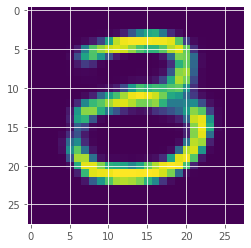

Train Epoch: 15 [2800/60000 (21%)]	 KLD Loss: 3.539440 	 NLL Loss: 74.384171


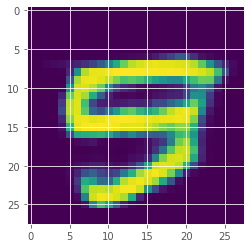

Train Epoch: 15 [5600/60000 (43%)]	 KLD Loss: 3.370620 	 NLL Loss: 71.295479


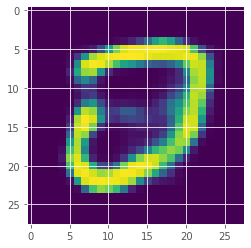

Train Epoch: 15 [8400/60000 (64%)]	 KLD Loss: 3.421719 	 NLL Loss: 70.255089


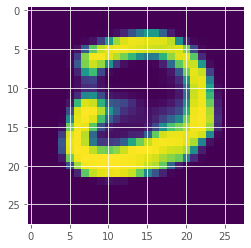

Train Epoch: 15 [11200/60000 (85%)]	 KLD Loss: 3.612788 	 NLL Loss: 75.069786


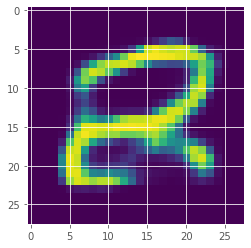

====> Epoch: 15 Average loss: 75.9053
====> Test set loss: KLD Loss = 3.3840, NLL Loss = 71.9493 
Train Epoch: 16 [0/60000 (0%)]	 KLD Loss: 3.372194 	 NLL Loss: 76.849335


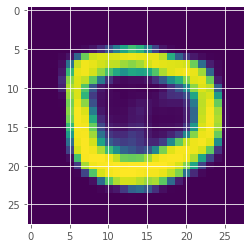

Train Epoch: 16 [2800/60000 (21%)]	 KLD Loss: 3.473777 	 NLL Loss: 71.757133


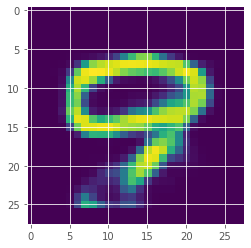

Train Epoch: 16 [5600/60000 (43%)]	 KLD Loss: 3.491894 	 NLL Loss: 76.434105


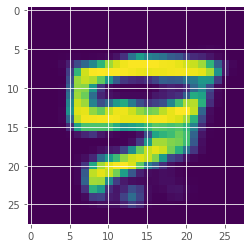

Train Epoch: 16 [8400/60000 (64%)]	 KLD Loss: 3.375847 	 NLL Loss: 72.692413


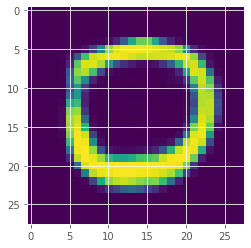

Train Epoch: 16 [11200/60000 (85%)]	 KLD Loss: 3.577582 	 NLL Loss: 71.964775


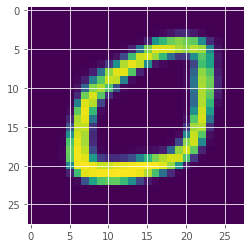

====> Epoch: 16 Average loss: 75.7228
====> Test set loss: KLD Loss = 3.4020, NLL Loss = 71.8457 
Train Epoch: 17 [0/60000 (0%)]	 KLD Loss: 3.557113 	 NLL Loss: 70.738045


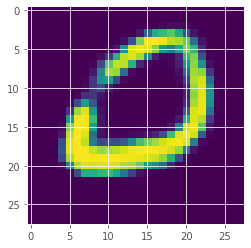

Train Epoch: 17 [2800/60000 (21%)]	 KLD Loss: 3.627845 	 NLL Loss: 71.971130


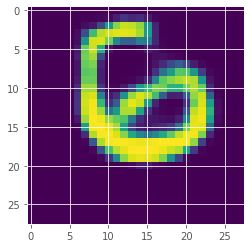

Train Epoch: 17 [5600/60000 (43%)]	 KLD Loss: 3.424419 	 NLL Loss: 70.326775


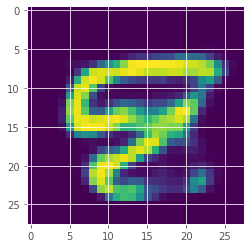

Train Epoch: 17 [8400/60000 (64%)]	 KLD Loss: 3.562713 	 NLL Loss: 70.241013


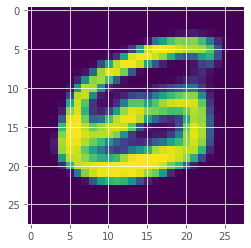

Train Epoch: 17 [11200/60000 (85%)]	 KLD Loss: 3.658235 	 NLL Loss: 69.167625


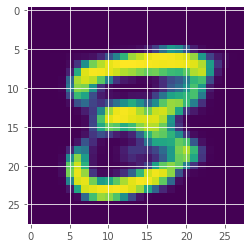

====> Epoch: 17 Average loss: 75.6336
====> Test set loss: KLD Loss = 3.6182, NLL Loss = 71.2729 
Train Epoch: 18 [0/60000 (0%)]	 KLD Loss: 3.434740 	 NLL Loss: 71.365623


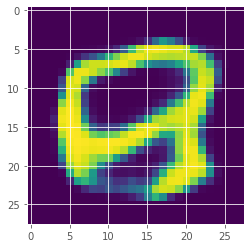

Train Epoch: 18 [2800/60000 (21%)]	 KLD Loss: 3.371026 	 NLL Loss: 70.037315


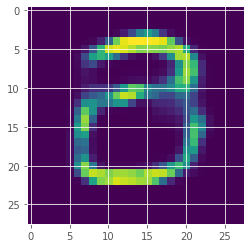

Train Epoch: 18 [5600/60000 (43%)]	 KLD Loss: 3.319953 	 NLL Loss: 71.645729


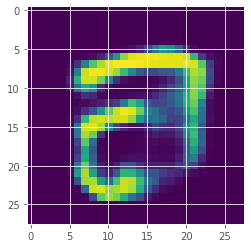

Train Epoch: 18 [8400/60000 (64%)]	 KLD Loss: 3.731818 	 NLL Loss: 71.555481


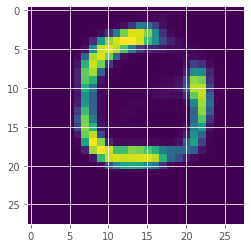

Train Epoch: 18 [11200/60000 (85%)]	 KLD Loss: 3.725004 	 NLL Loss: 73.369064


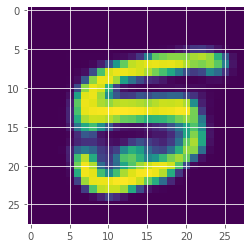

====> Epoch: 18 Average loss: 75.2032
====> Test set loss: KLD Loss = 3.5208, NLL Loss = 71.2417 
Train Epoch: 19 [0/60000 (0%)]	 KLD Loss: 3.583610 	 NLL Loss: 74.910538


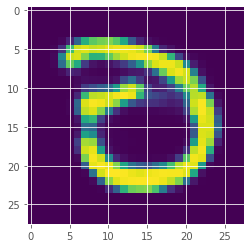

Train Epoch: 19 [2800/60000 (21%)]	 KLD Loss: 3.943442 	 NLL Loss: 72.582573


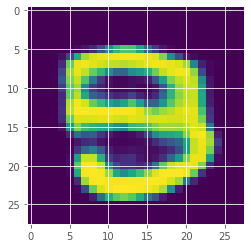

Train Epoch: 19 [5600/60000 (43%)]	 KLD Loss: 3.537720 	 NLL Loss: 69.999420


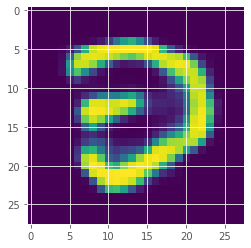

Train Epoch: 19 [8400/60000 (64%)]	 KLD Loss: 3.546570 	 NLL Loss: 71.481926


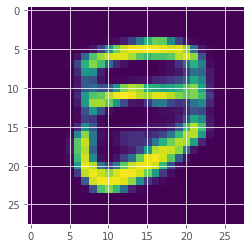

Train Epoch: 19 [11200/60000 (85%)]	 KLD Loss: 3.858829 	 NLL Loss: 72.764999


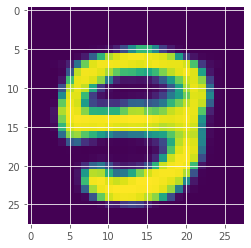

====> Epoch: 19 Average loss: 75.5723
====> Test set loss: KLD Loss = 3.5137, NLL Loss = 71.1990 
Train Epoch: 20 [0/60000 (0%)]	 KLD Loss: 3.617099 	 NLL Loss: 72.281715


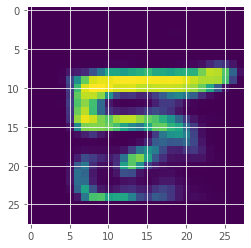

Train Epoch: 20 [2800/60000 (21%)]	 KLD Loss: 3.508174 	 NLL Loss: 71.987671


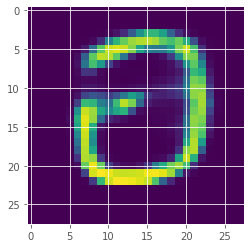

Train Epoch: 20 [5600/60000 (43%)]	 KLD Loss: 3.453834 	 NLL Loss: 69.188477


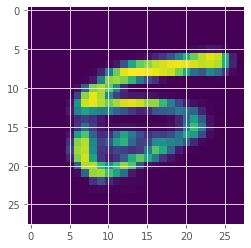

Train Epoch: 20 [8400/60000 (64%)]	 KLD Loss: 3.675903 	 NLL Loss: 71.342186


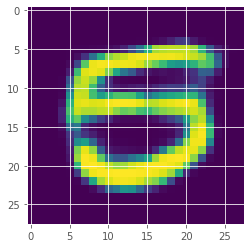

Train Epoch: 20 [11200/60000 (85%)]	 KLD Loss: 3.711108 	 NLL Loss: 71.748146


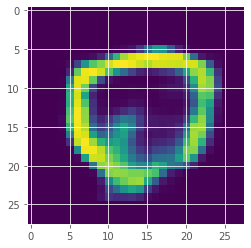

====> Epoch: 20 Average loss: 74.9190
====> Test set loss: KLD Loss = 3.6551, NLL Loss = 70.8205 
Train Epoch: 21 [0/60000 (0%)]	 KLD Loss: 3.834044 	 NLL Loss: 71.999939


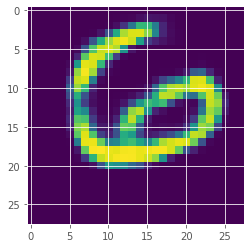

Train Epoch: 21 [2800/60000 (21%)]	 KLD Loss: 4.003217 	 NLL Loss: 71.809814


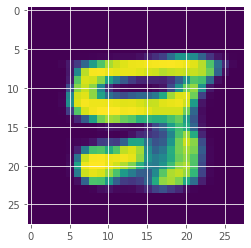

Train Epoch: 21 [5600/60000 (43%)]	 KLD Loss: 3.449682 	 NLL Loss: 72.269081


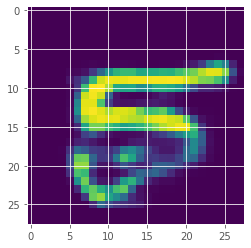

Train Epoch: 21 [8400/60000 (64%)]	 KLD Loss: 3.365560 	 NLL Loss: 70.398117


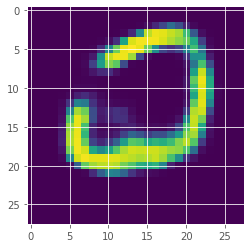

Train Epoch: 21 [11200/60000 (85%)]	 KLD Loss: 3.461492 	 NLL Loss: 68.708893


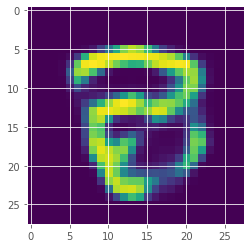

====> Epoch: 21 Average loss: 74.8494
====> Test set loss: KLD Loss = 3.5135, NLL Loss = 70.8358 
Saved model to saves/vrnn_state_dict_21.pth
Train Epoch: 22 [0/60000 (0%)]	 KLD Loss: 3.403047 	 NLL Loss: 67.652313


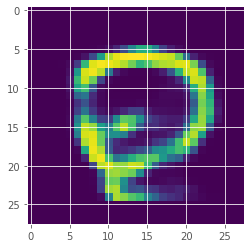

Train Epoch: 22 [2800/60000 (21%)]	 KLD Loss: 3.473349 	 NLL Loss: 68.824188


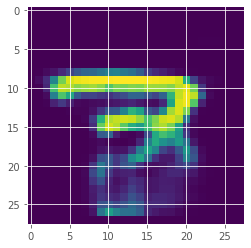

Train Epoch: 22 [5600/60000 (43%)]	 KLD Loss: 3.504599 	 NLL Loss: 71.546890


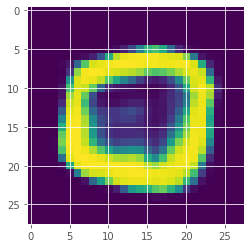

Train Epoch: 22 [8400/60000 (64%)]	 KLD Loss: 3.606072 	 NLL Loss: 67.764816


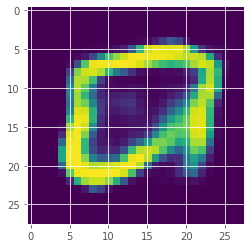

Train Epoch: 22 [11200/60000 (85%)]	 KLD Loss: 3.498824 	 NLL Loss: 70.779541


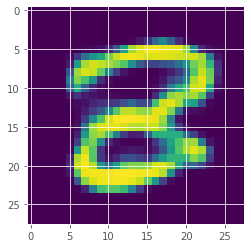

====> Epoch: 22 Average loss: 74.5991
====> Test set loss: KLD Loss = 3.8156, NLL Loss = 70.4027 
Train Epoch: 23 [0/60000 (0%)]	 KLD Loss: 3.750924 	 NLL Loss: 70.861877


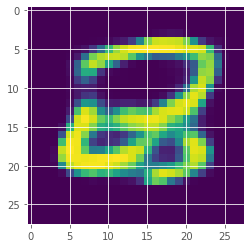

Train Epoch: 23 [2800/60000 (21%)]	 KLD Loss: 3.641617 	 NLL Loss: 71.533539


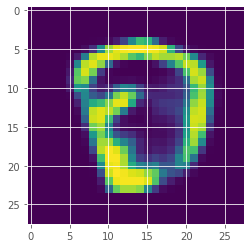

Train Epoch: 23 [5600/60000 (43%)]	 KLD Loss: 3.702440 	 NLL Loss: 69.742249


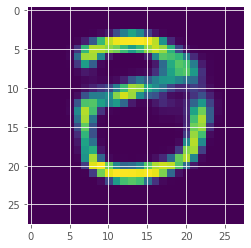

Train Epoch: 23 [8400/60000 (64%)]	 KLD Loss: 4.094095 	 NLL Loss: 73.052803


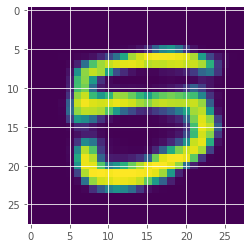

Train Epoch: 23 [11200/60000 (85%)]	 KLD Loss: 3.937371 	 NLL Loss: 71.155670


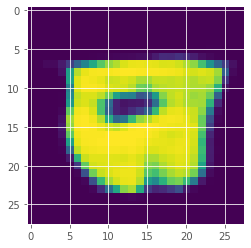

====> Epoch: 23 Average loss: 74.8630
====> Test set loss: KLD Loss = 3.6828, NLL Loss = 70.9717 
Train Epoch: 24 [0/60000 (0%)]	 KLD Loss: 3.851678 	 NLL Loss: 71.046967


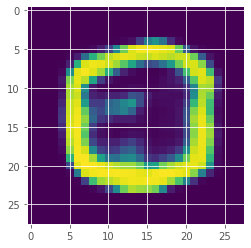

Train Epoch: 24 [2800/60000 (21%)]	 KLD Loss: 3.796540 	 NLL Loss: 72.272163


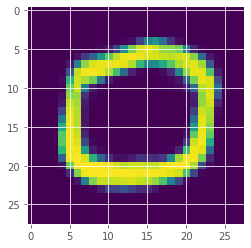

Train Epoch: 24 [5600/60000 (43%)]	 KLD Loss: 3.486853 	 NLL Loss: 69.038139


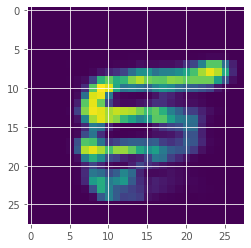

Train Epoch: 24 [8400/60000 (64%)]	 KLD Loss: 4.077550 	 NLL Loss: 71.080627


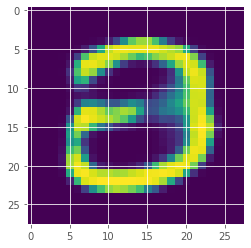

Train Epoch: 24 [11200/60000 (85%)]	 KLD Loss: 3.767812 	 NLL Loss: 71.186150


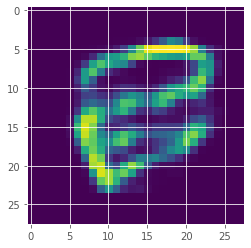

====> Epoch: 24 Average loss: 74.6244
====> Test set loss: KLD Loss = 3.8145, NLL Loss = 69.9810 
Train Epoch: 25 [0/60000 (0%)]	 KLD Loss: 3.733791 	 NLL Loss: 72.123932


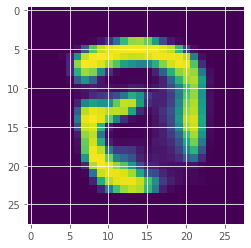

Train Epoch: 25 [2800/60000 (21%)]	 KLD Loss: 3.586770 	 NLL Loss: 69.057518


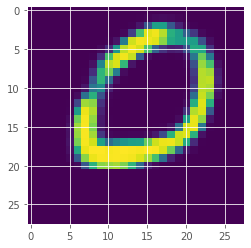

Train Epoch: 25 [5600/60000 (43%)]	 KLD Loss: 3.739516 	 NLL Loss: 71.164848


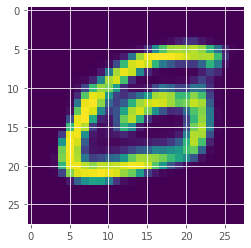

Train Epoch: 25 [8400/60000 (64%)]	 KLD Loss: 3.667732 	 NLL Loss: 72.855949


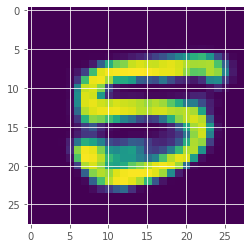

Train Epoch: 25 [11200/60000 (85%)]	 KLD Loss: 3.881433 	 NLL Loss: 69.710793


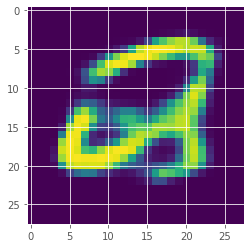

====> Epoch: 25 Average loss: 74.2725
====> Test set loss: KLD Loss = 4.1942, NLL Loss = 73.4899 
Train Epoch: 26 [0/60000 (0%)]	 KLD Loss: 4.156869 	 NLL Loss: 73.730736


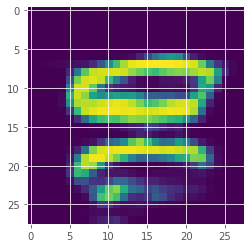

Train Epoch: 26 [2800/60000 (21%)]	 KLD Loss: 4.020731 	 NLL Loss: 70.160934


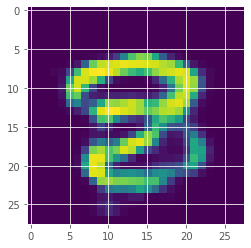

Train Epoch: 26 [5600/60000 (43%)]	 KLD Loss: 4.078779 	 NLL Loss: 72.297150


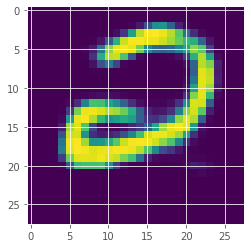

Train Epoch: 26 [8400/60000 (64%)]	 KLD Loss: 3.817501 	 NLL Loss: 69.072449


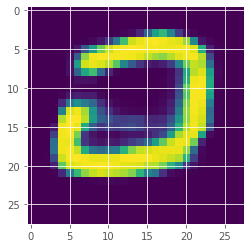

Train Epoch: 26 [11200/60000 (85%)]	 KLD Loss: 3.925182 	 NLL Loss: 71.087463


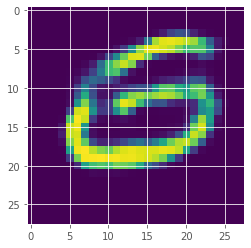

====> Epoch: 26 Average loss: 74.5655
====> Test set loss: KLD Loss = 3.8837, NLL Loss = 69.7593 
Train Epoch: 27 [0/60000 (0%)]	 KLD Loss: 3.842197 	 NLL Loss: 69.584892


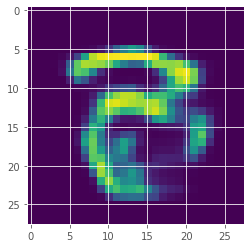

Train Epoch: 27 [2800/60000 (21%)]	 KLD Loss: 3.752457 	 NLL Loss: 71.277519


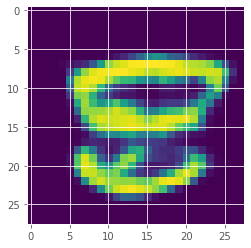

Train Epoch: 27 [5600/60000 (43%)]	 KLD Loss: 3.700980 	 NLL Loss: 68.588501


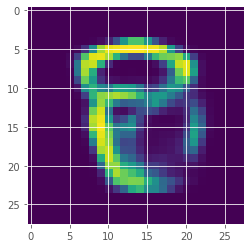

Train Epoch: 27 [8400/60000 (64%)]	 KLD Loss: 4.086973 	 NLL Loss: 70.943474


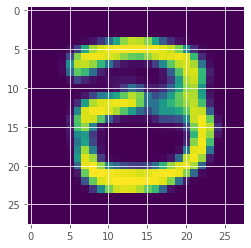

Train Epoch: 27 [11200/60000 (85%)]	 KLD Loss: 4.051330 	 NLL Loss: 71.004318


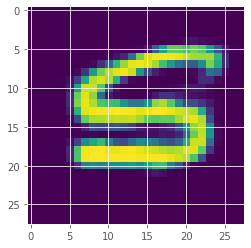

====> Epoch: 27 Average loss: 74.7587
====> Test set loss: KLD Loss = 4.0111, NLL Loss = 71.0347 
Train Epoch: 28 [0/60000 (0%)]	 KLD Loss: 3.984742 	 NLL Loss: 73.262245


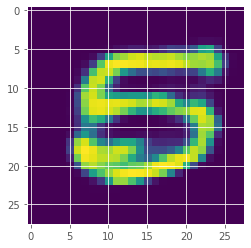

Train Epoch: 28 [2800/60000 (21%)]	 KLD Loss: 4.237924 	 NLL Loss: 74.690796


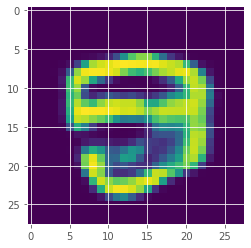

Train Epoch: 28 [5600/60000 (43%)]	 KLD Loss: 3.933320 	 NLL Loss: 67.185944


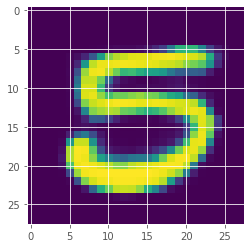

Train Epoch: 28 [8400/60000 (64%)]	 KLD Loss: 3.771556 	 NLL Loss: 66.399010


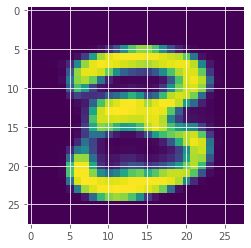

Train Epoch: 28 [11200/60000 (85%)]	 KLD Loss: 4.102376 	 NLL Loss: 71.495232


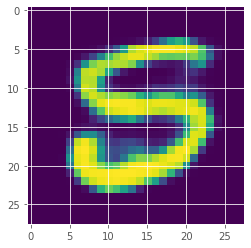

====> Epoch: 28 Average loss: 74.2917
====> Test set loss: KLD Loss = 4.1149, NLL Loss = 69.3551 
Train Epoch: 29 [0/60000 (0%)]	 KLD Loss: 4.264915 	 NLL Loss: 68.752235


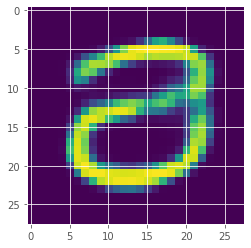

Train Epoch: 29 [2800/60000 (21%)]	 KLD Loss: 4.037381 	 NLL Loss: 67.937592


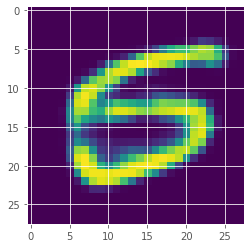

Train Epoch: 29 [5600/60000 (43%)]	 KLD Loss: 4.290262 	 NLL Loss: 68.110847


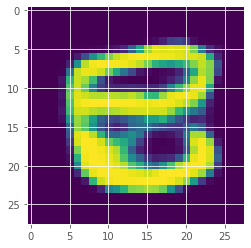

Train Epoch: 29 [8400/60000 (64%)]	 KLD Loss: 3.986043 	 NLL Loss: 69.341499


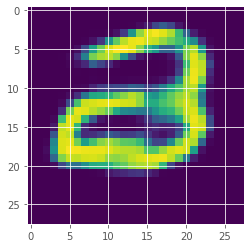

Train Epoch: 29 [11200/60000 (85%)]	 KLD Loss: 4.011099 	 NLL Loss: 70.492813


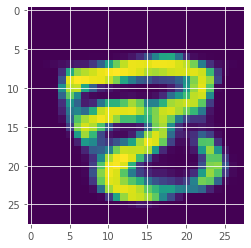

====> Epoch: 29 Average loss: 74.2270
====> Test set loss: KLD Loss = 3.8901, NLL Loss = 69.8202 
Train Epoch: 30 [0/60000 (0%)]	 KLD Loss: 4.001264 	 NLL Loss: 72.794769


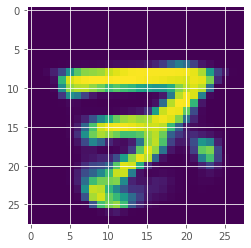

Train Epoch: 30 [2800/60000 (21%)]	 KLD Loss: 3.795701 	 NLL Loss: 69.487534


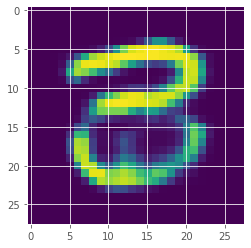

Train Epoch: 30 [5600/60000 (43%)]	 KLD Loss: 3.977036 	 NLL Loss: 69.217690


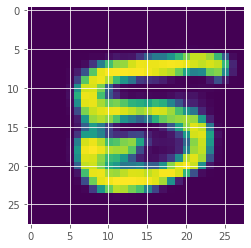

Train Epoch: 30 [8400/60000 (64%)]	 KLD Loss: 4.057541 	 NLL Loss: 68.253433


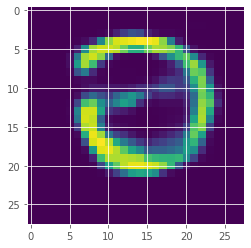

Train Epoch: 30 [11200/60000 (85%)]	 KLD Loss: 3.942328 	 NLL Loss: 68.222977


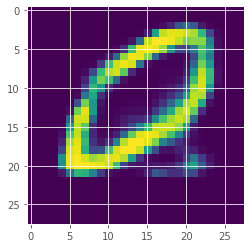

====> Epoch: 30 Average loss: 73.7250
====> Test set loss: KLD Loss = 3.9068, NLL Loss = 69.5186 
Train Epoch: 31 [0/60000 (0%)]	 KLD Loss: 3.780896 	 NLL Loss: 72.638168


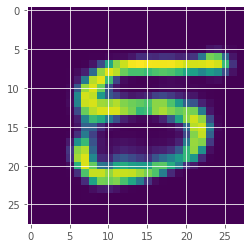

Train Epoch: 31 [2800/60000 (21%)]	 KLD Loss: 3.827227 	 NLL Loss: 70.730675


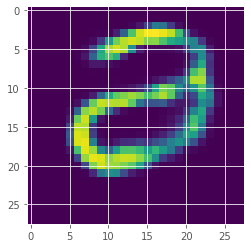

Train Epoch: 31 [5600/60000 (43%)]	 KLD Loss: 3.874489 	 NLL Loss: 68.751602


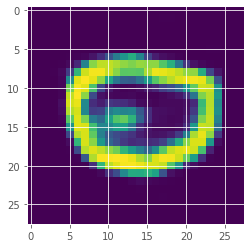

Train Epoch: 31 [8400/60000 (64%)]	 KLD Loss: 4.094291 	 NLL Loss: 69.867928


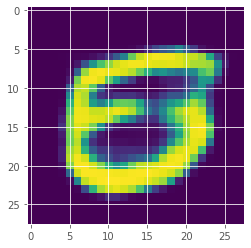

Train Epoch: 31 [11200/60000 (85%)]	 KLD Loss: 3.996447 	 NLL Loss: 70.715820


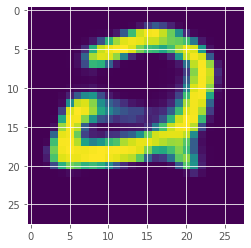

====> Epoch: 31 Average loss: 73.6362
====> Test set loss: KLD Loss = 4.1169, NLL Loss = 69.0959 
Saved model to saves/vrnn_state_dict_31.pth
Train Epoch: 32 [0/60000 (0%)]	 KLD Loss: 4.030199 	 NLL Loss: 69.787163


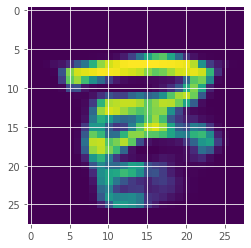

Train Epoch: 32 [2800/60000 (21%)]	 KLD Loss: 4.135147 	 NLL Loss: 71.234695


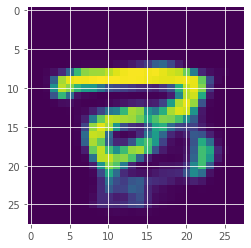

Train Epoch: 32 [5600/60000 (43%)]	 KLD Loss: 3.945954 	 NLL Loss: 71.799728


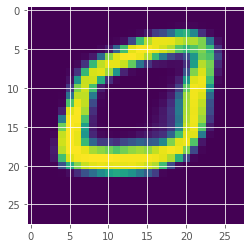

Train Epoch: 32 [8400/60000 (64%)]	 KLD Loss: 3.991555 	 NLL Loss: 68.693222


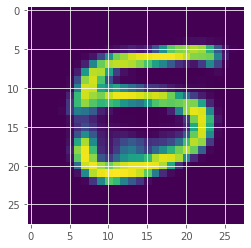

Train Epoch: 32 [11200/60000 (85%)]	 KLD Loss: 4.400301 	 NLL Loss: 71.327888


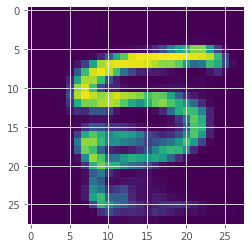

====> Epoch: 32 Average loss: 73.7329
====> Test set loss: KLD Loss = 4.0366, NLL Loss = 69.3360 
Train Epoch: 33 [0/60000 (0%)]	 KLD Loss: 3.861887 	 NLL Loss: 68.758629


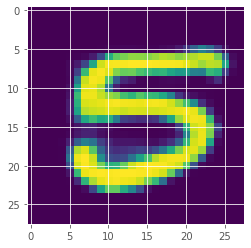

Train Epoch: 33 [2800/60000 (21%)]	 KLD Loss: 3.907808 	 NLL Loss: 71.397835


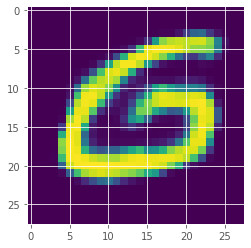

Train Epoch: 33 [5600/60000 (43%)]	 KLD Loss: 4.590020 	 NLL Loss: 73.814148


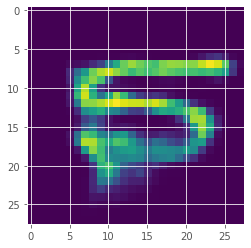

Train Epoch: 33 [8400/60000 (64%)]	 KLD Loss: 3.887280 	 NLL Loss: 71.303017


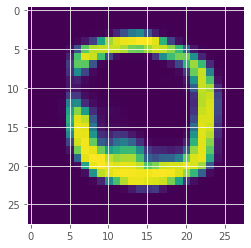

Train Epoch: 33 [11200/60000 (85%)]	 KLD Loss: 3.929154 	 NLL Loss: 67.951958


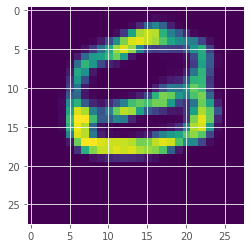

====> Epoch: 33 Average loss: 74.0447
====> Test set loss: KLD Loss = 4.0980, NLL Loss = 68.9680 
Train Epoch: 34 [0/60000 (0%)]	 KLD Loss: 4.006922 	 NLL Loss: 67.733139


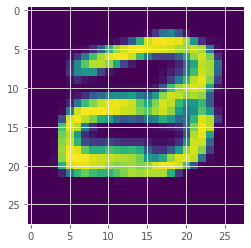

Train Epoch: 34 [2800/60000 (21%)]	 KLD Loss: 4.283327 	 NLL Loss: 67.316185


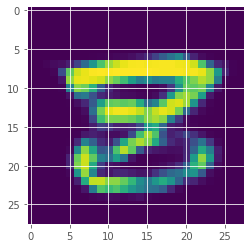

Train Epoch: 34 [5600/60000 (43%)]	 KLD Loss: 4.374563 	 NLL Loss: 70.882423


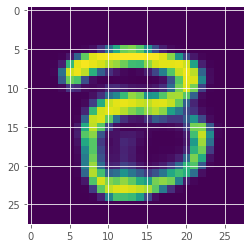

Train Epoch: 34 [8400/60000 (64%)]	 KLD Loss: 4.169299 	 NLL Loss: 71.061417


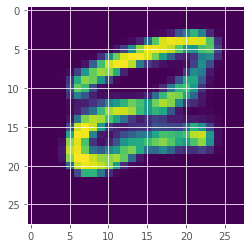

Train Epoch: 34 [11200/60000 (85%)]	 KLD Loss: 4.112147 	 NLL Loss: 70.116829


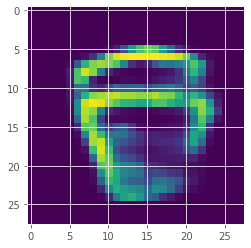

====> Epoch: 34 Average loss: 73.3258
====> Test set loss: KLD Loss = 4.0966, NLL Loss = 68.9721 
Train Epoch: 35 [0/60000 (0%)]	 KLD Loss: 4.213722 	 NLL Loss: 70.899826


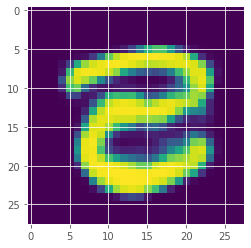

Train Epoch: 35 [2800/60000 (21%)]	 KLD Loss: 3.771144 	 NLL Loss: 67.848022


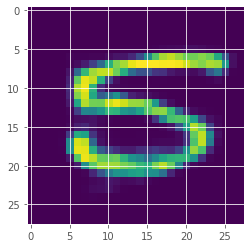

Train Epoch: 35 [5600/60000 (43%)]	 KLD Loss: 4.575184 	 NLL Loss: 71.815948


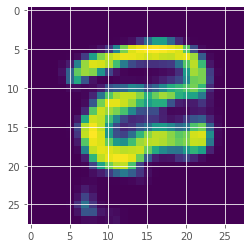

Train Epoch: 35 [8400/60000 (64%)]	 KLD Loss: 4.210567 	 NLL Loss: 69.454628


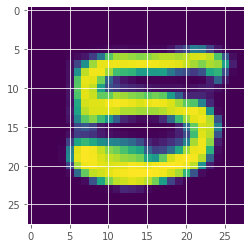

Train Epoch: 35 [11200/60000 (85%)]	 KLD Loss: 4.314550 	 NLL Loss: 68.625031


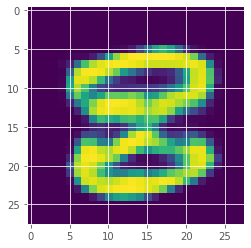

====> Epoch: 35 Average loss: 73.3795
====> Test set loss: KLD Loss = 4.1448, NLL Loss = 68.7140 
Train Epoch: 36 [0/60000 (0%)]	 KLD Loss: 4.278172 	 NLL Loss: 68.616043


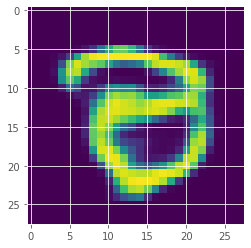

Train Epoch: 36 [2800/60000 (21%)]	 KLD Loss: 4.034290 	 NLL Loss: 72.388046


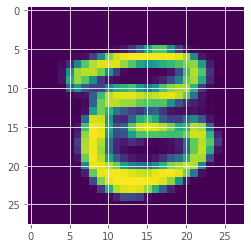

Train Epoch: 36 [5600/60000 (43%)]	 KLD Loss: 4.168233 	 NLL Loss: 65.715248


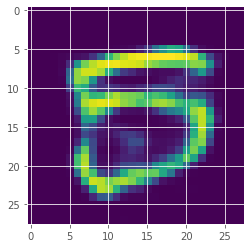

Train Epoch: 36 [8400/60000 (64%)]	 KLD Loss: 3.952187 	 NLL Loss: 67.538849


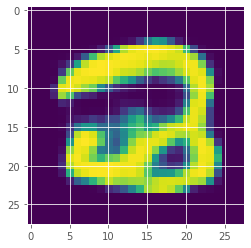

Train Epoch: 36 [11200/60000 (85%)]	 KLD Loss: 4.390704 	 NLL Loss: 69.208855


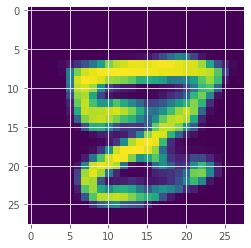

====> Epoch: 36 Average loss: 73.1369
====> Test set loss: KLD Loss = 4.2241, NLL Loss = 68.6078 
Train Epoch: 37 [0/60000 (0%)]	 KLD Loss: 4.166469 	 NLL Loss: 67.514168


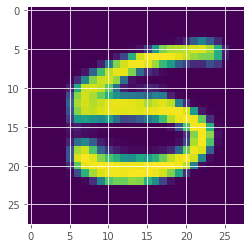

Train Epoch: 37 [2800/60000 (21%)]	 KLD Loss: 4.174836 	 NLL Loss: 69.823616


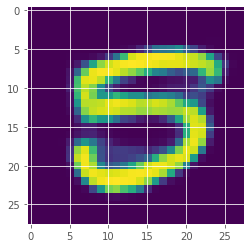

Train Epoch: 37 [5600/60000 (43%)]	 KLD Loss: 4.182675 	 NLL Loss: 70.213142


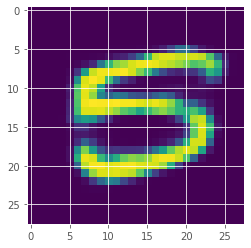

Train Epoch: 37 [8400/60000 (64%)]	 KLD Loss: 3.805443 	 NLL Loss: 69.416107


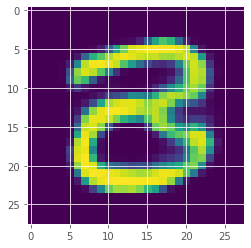

Train Epoch: 37 [11200/60000 (85%)]	 KLD Loss: 4.100392 	 NLL Loss: 69.896095


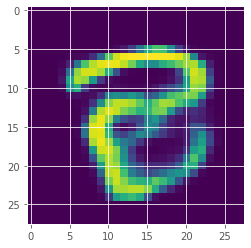

====> Epoch: 37 Average loss: 73.4569
====> Test set loss: KLD Loss = 3.9498, NLL Loss = 70.1046 
Train Epoch: 38 [0/60000 (0%)]	 KLD Loss: 3.816956 	 NLL Loss: 68.540558


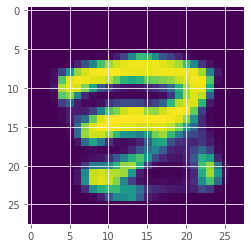

Train Epoch: 38 [2800/60000 (21%)]	 KLD Loss: 4.238403 	 NLL Loss: 68.036705


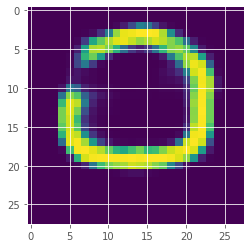

Train Epoch: 38 [5600/60000 (43%)]	 KLD Loss: 4.173166 	 NLL Loss: 70.750916


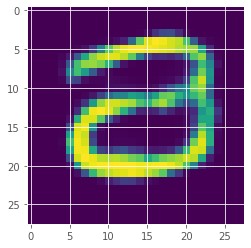

Train Epoch: 38 [8400/60000 (64%)]	 KLD Loss: 4.268314 	 NLL Loss: 69.930351


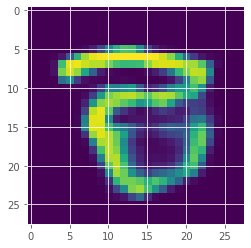

Train Epoch: 38 [11200/60000 (85%)]	 KLD Loss: 3.981039 	 NLL Loss: 67.858780


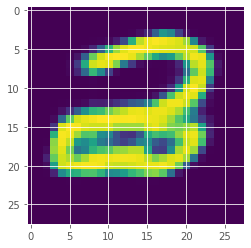

====> Epoch: 38 Average loss: 73.2465
====> Test set loss: KLD Loss = 4.1058, NLL Loss = 68.6583 
Train Epoch: 39 [0/60000 (0%)]	 KLD Loss: 4.240638 	 NLL Loss: 70.099388


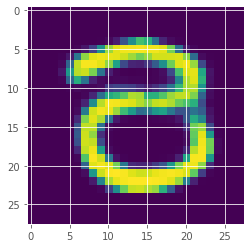

Train Epoch: 39 [2800/60000 (21%)]	 KLD Loss: 4.120099 	 NLL Loss: 68.283440


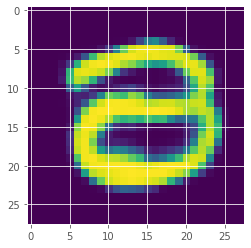

Train Epoch: 39 [5600/60000 (43%)]	 KLD Loss: 3.926020 	 NLL Loss: 68.018333


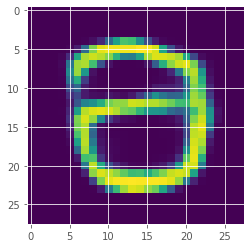

Train Epoch: 39 [8400/60000 (64%)]	 KLD Loss: 4.139031 	 NLL Loss: 67.391113


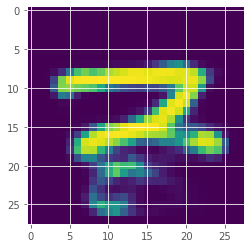

Train Epoch: 39 [11200/60000 (85%)]	 KLD Loss: 4.432868 	 NLL Loss: 67.508980


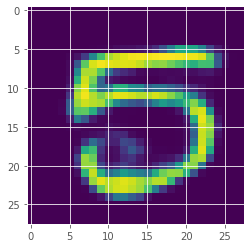

====> Epoch: 39 Average loss: 72.9234
====> Test set loss: KLD Loss = 4.1145, NLL Loss = 68.4749 
Train Epoch: 40 [0/60000 (0%)]	 KLD Loss: 4.201626 	 NLL Loss: 67.799454


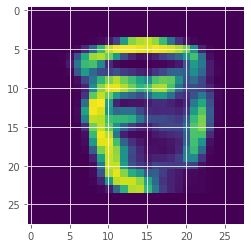

Train Epoch: 40 [2800/60000 (21%)]	 KLD Loss: 4.058012 	 NLL Loss: 68.114288


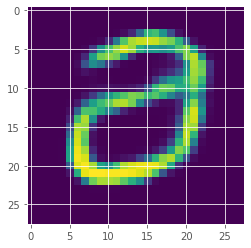

Train Epoch: 40 [5600/60000 (43%)]	 KLD Loss: 3.982833 	 NLL Loss: 67.300728


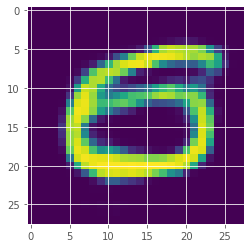

Train Epoch: 40 [8400/60000 (64%)]	 KLD Loss: 4.121930 	 NLL Loss: 66.538162


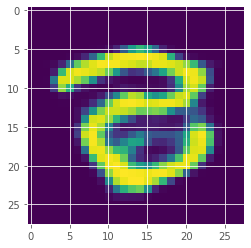

Train Epoch: 40 [11200/60000 (85%)]	 KLD Loss: 4.133266 	 NLL Loss: 67.667862


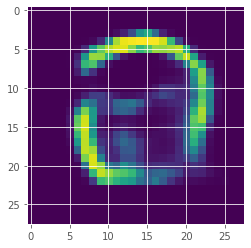

====> Epoch: 40 Average loss: 72.9778
====> Test set loss: KLD Loss = 4.2424, NLL Loss = 68.2935 
Train Epoch: 41 [0/60000 (0%)]	 KLD Loss: 4.419817 	 NLL Loss: 71.115257


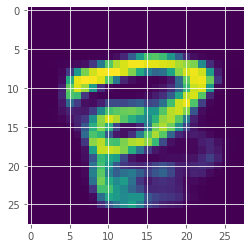

Train Epoch: 41 [2800/60000 (21%)]	 KLD Loss: 4.250301 	 NLL Loss: 69.414726


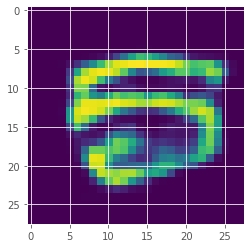

Train Epoch: 41 [5600/60000 (43%)]	 KLD Loss: 4.240752 	 NLL Loss: 71.216148


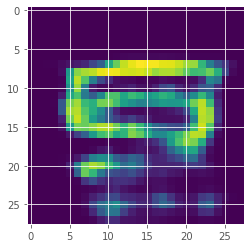

Train Epoch: 41 [8400/60000 (64%)]	 KLD Loss: 4.204652 	 NLL Loss: 69.823257


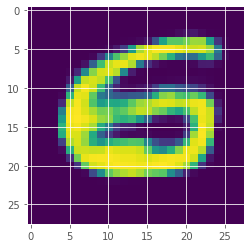

Train Epoch: 41 [11200/60000 (85%)]	 KLD Loss: 4.352860 	 NLL Loss: 69.502159


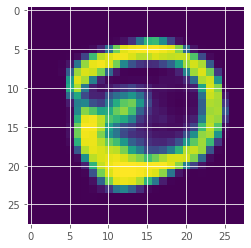

====> Epoch: 41 Average loss: 74.0195
====> Test set loss: KLD Loss = 3.9581, NLL Loss = 69.2923 
Saved model to saves/vrnn_state_dict_41.pth
Train Epoch: 42 [0/60000 (0%)]	 KLD Loss: 4.012799 	 NLL Loss: 67.291145


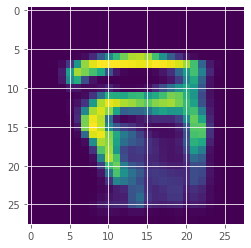

Train Epoch: 42 [2800/60000 (21%)]	 KLD Loss: 4.170337 	 NLL Loss: 67.093880


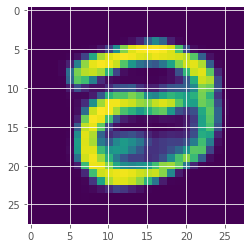

Train Epoch: 42 [5600/60000 (43%)]	 KLD Loss: 4.009201 	 NLL Loss: 68.346260


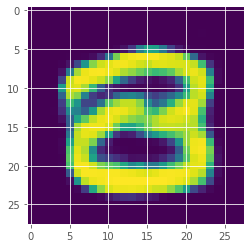

Train Epoch: 42 [8400/60000 (64%)]	 KLD Loss: 4.142613 	 NLL Loss: 66.750595


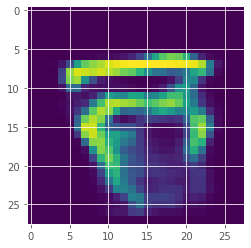

Train Epoch: 42 [11200/60000 (85%)]	 KLD Loss: 4.011514 	 NLL Loss: 69.899635


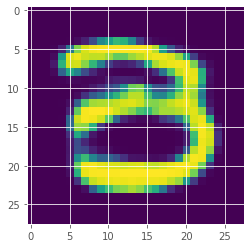

====> Epoch: 42 Average loss: 72.9991
====> Test set loss: KLD Loss = 4.0660, NLL Loss = 68.5419 
Train Epoch: 43 [0/60000 (0%)]	 KLD Loss: 4.255398 	 NLL Loss: 69.797646


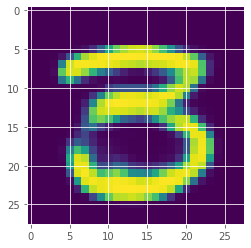

Train Epoch: 43 [2800/60000 (21%)]	 KLD Loss: 4.118455 	 NLL Loss: 67.277046


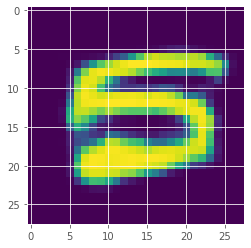

Train Epoch: 43 [5600/60000 (43%)]	 KLD Loss: 4.322084 	 NLL Loss: 68.039665


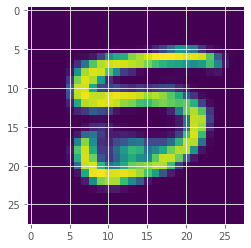

Train Epoch: 43 [8400/60000 (64%)]	 KLD Loss: 4.168145 	 NLL Loss: 68.833252


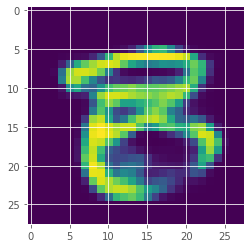

Train Epoch: 43 [11200/60000 (85%)]	 KLD Loss: 4.128611 	 NLL Loss: 67.875015


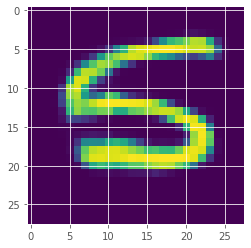

====> Epoch: 43 Average loss: 72.8068
====> Test set loss: KLD Loss = 4.1223, NLL Loss = 69.1323 
Train Epoch: 44 [0/60000 (0%)]	 KLD Loss: 4.181684 	 NLL Loss: 70.738655


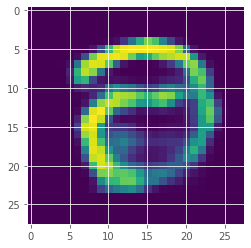

Train Epoch: 44 [2800/60000 (21%)]	 KLD Loss: 4.226682 	 NLL Loss: 67.423027


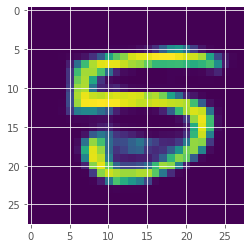

Train Epoch: 44 [5600/60000 (43%)]	 KLD Loss: 3.874187 	 NLL Loss: 68.731827


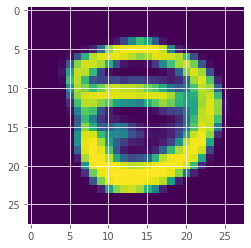

Train Epoch: 44 [8400/60000 (64%)]	 KLD Loss: 3.812668 	 NLL Loss: 69.105995


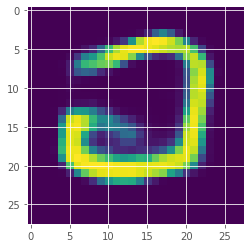

Train Epoch: 44 [11200/60000 (85%)]	 KLD Loss: 4.465143 	 NLL Loss: 67.130928


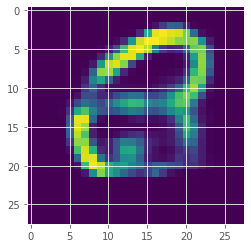

====> Epoch: 44 Average loss: 72.6495
====> Test set loss: KLD Loss = 4.1778, NLL Loss = 68.3885 
Train Epoch: 45 [0/60000 (0%)]	 KLD Loss: 4.234096 	 NLL Loss: 68.962372


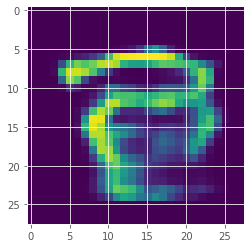

Train Epoch: 45 [2800/60000 (21%)]	 KLD Loss: 4.606413 	 NLL Loss: 68.262039


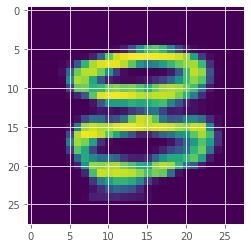

Train Epoch: 45 [5600/60000 (43%)]	 KLD Loss: 4.023480 	 NLL Loss: 66.446930


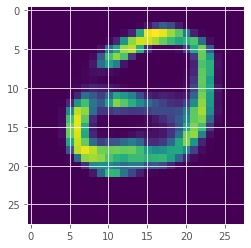

Train Epoch: 45 [8400/60000 (64%)]	 KLD Loss: 4.163940 	 NLL Loss: 68.016029


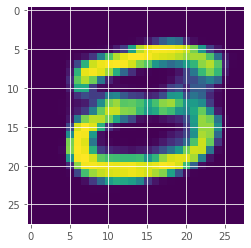

Train Epoch: 45 [11200/60000 (85%)]	 KLD Loss: 4.346790 	 NLL Loss: 69.277672


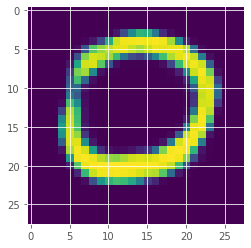

====> Epoch: 45 Average loss: 72.5443
====> Test set loss: KLD Loss = 4.1440, NLL Loss = 68.3330 
Train Epoch: 46 [0/60000 (0%)]	 KLD Loss: 4.075412 	 NLL Loss: 66.656738


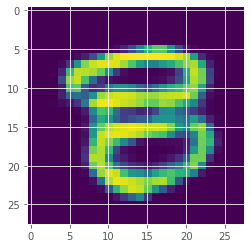

Train Epoch: 46 [2800/60000 (21%)]	 KLD Loss: 4.065940 	 NLL Loss: 68.350868


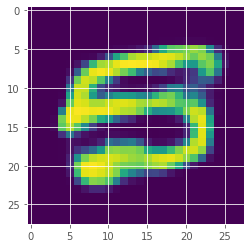

Train Epoch: 46 [5600/60000 (43%)]	 KLD Loss: 4.040276 	 NLL Loss: 64.324379


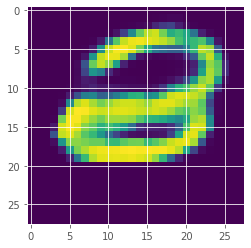

Train Epoch: 46 [8400/60000 (64%)]	 KLD Loss: 4.163365 	 NLL Loss: 68.260696


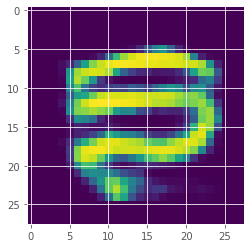

Train Epoch: 46 [11200/60000 (85%)]	 KLD Loss: 4.171944 	 NLL Loss: 72.408112


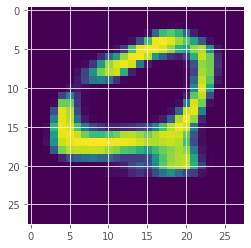

====> Epoch: 46 Average loss: 72.6691
====> Test set loss: KLD Loss = 4.1918, NLL Loss = 69.1747 
Train Epoch: 47 [0/60000 (0%)]	 KLD Loss: 4.069942 	 NLL Loss: 72.193764


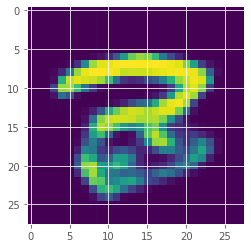

Train Epoch: 47 [2800/60000 (21%)]	 KLD Loss: 4.214195 	 NLL Loss: 68.878563


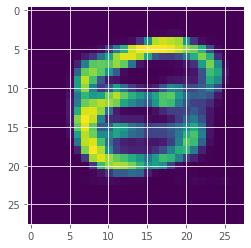

Train Epoch: 47 [5600/60000 (43%)]	 KLD Loss: 3.910550 	 NLL Loss: 68.760521


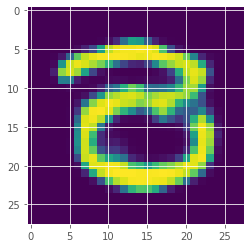

Train Epoch: 47 [8400/60000 (64%)]	 KLD Loss: 4.134577 	 NLL Loss: 68.242477


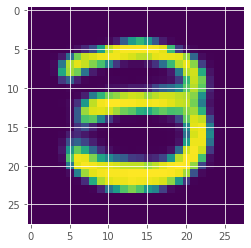

Train Epoch: 47 [11200/60000 (85%)]	 KLD Loss: 4.021372 	 NLL Loss: 68.494919


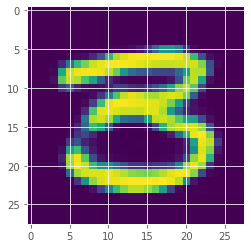

====> Epoch: 47 Average loss: 72.4835
====> Test set loss: KLD Loss = 4.2383, NLL Loss = 68.1540 
Train Epoch: 48 [0/60000 (0%)]	 KLD Loss: 4.204518 	 NLL Loss: 66.829605


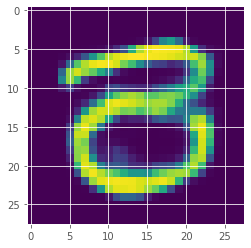

Train Epoch: 48 [2800/60000 (21%)]	 KLD Loss: 3.961221 	 NLL Loss: 71.274513


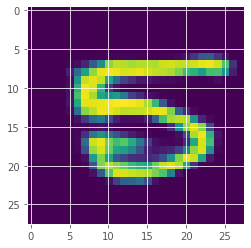

Train Epoch: 48 [5600/60000 (43%)]	 KLD Loss: 4.250317 	 NLL Loss: 70.501137


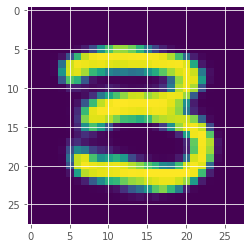

Train Epoch: 48 [8400/60000 (64%)]	 KLD Loss: 4.200066 	 NLL Loss: 68.890381


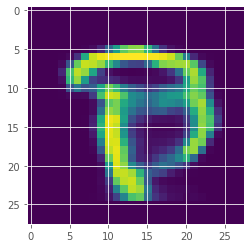

Train Epoch: 48 [11200/60000 (85%)]	 KLD Loss: 4.030314 	 NLL Loss: 69.282822


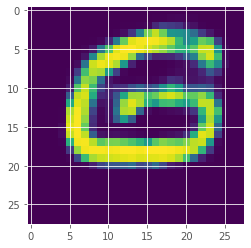

====> Epoch: 48 Average loss: 72.6465
====> Test set loss: KLD Loss = 4.3358, NLL Loss = 67.7811 
Train Epoch: 49 [0/60000 (0%)]	 KLD Loss: 4.420298 	 NLL Loss: 68.615929


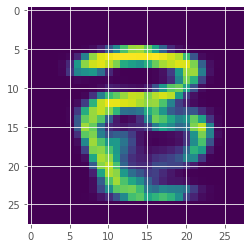

Train Epoch: 49 [2800/60000 (21%)]	 KLD Loss: 4.420246 	 NLL Loss: 69.161240


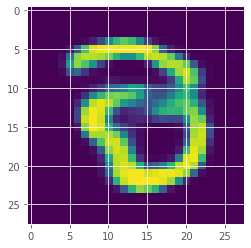

Train Epoch: 49 [5600/60000 (43%)]	 KLD Loss: 4.250047 	 NLL Loss: 70.281647


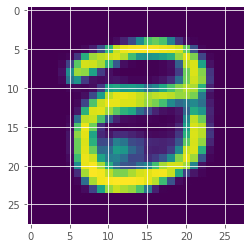

Train Epoch: 49 [8400/60000 (64%)]	 KLD Loss: 4.292035 	 NLL Loss: 69.136993


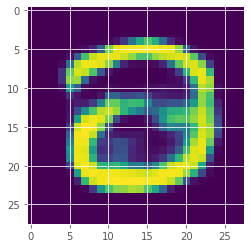

Train Epoch: 49 [11200/60000 (85%)]	 KLD Loss: 4.243977 	 NLL Loss: 68.595398


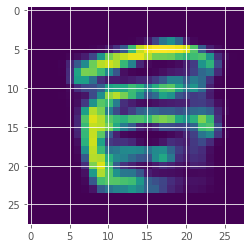

====> Epoch: 49 Average loss: 72.6769
====> Test set loss: KLD Loss = 4.2509, NLL Loss = 69.7530 
Train Epoch: 50 [0/60000 (0%)]	 KLD Loss: 3.996224 	 NLL Loss: 63.896542


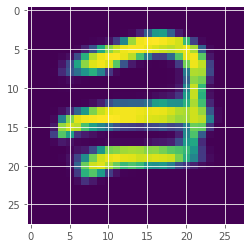

Train Epoch: 50 [2800/60000 (21%)]	 KLD Loss: 4.103622 	 NLL Loss: 71.474785


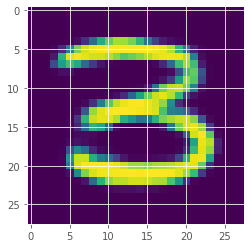

Train Epoch: 50 [5600/60000 (43%)]	 KLD Loss: 3.853117 	 NLL Loss: 69.878830


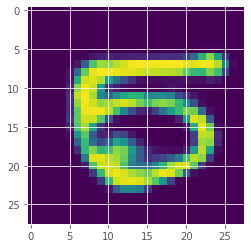

Train Epoch: 50 [8400/60000 (64%)]	 KLD Loss: 4.197228 	 NLL Loss: 71.048149


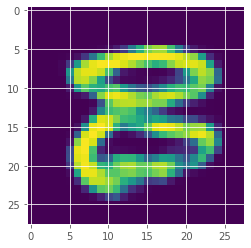

Train Epoch: 50 [11200/60000 (85%)]	 KLD Loss: 4.090452 	 NLL Loss: 66.435570


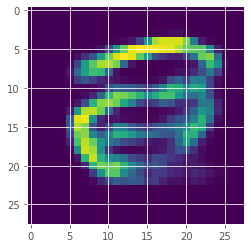

====> Epoch: 50 Average loss: 72.6602
====> Test set loss: KLD Loss = 4.1636, NLL Loss = 71.5305 
Train Epoch: 51 [0/60000 (0%)]	 KLD Loss: 4.405650 	 NLL Loss: 70.048134


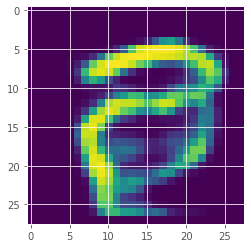

Train Epoch: 51 [2800/60000 (21%)]	 KLD Loss: 4.337832 	 NLL Loss: 70.424362


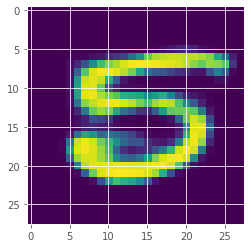

Train Epoch: 51 [5600/60000 (43%)]	 KLD Loss: 3.797876 	 NLL Loss: 66.514557


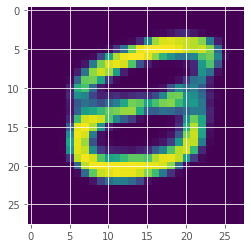

Train Epoch: 51 [8400/60000 (64%)]	 KLD Loss: 4.179646 	 NLL Loss: 66.974304


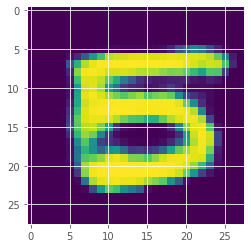

Train Epoch: 51 [11200/60000 (85%)]	 KLD Loss: 4.009887 	 NLL Loss: 69.220909


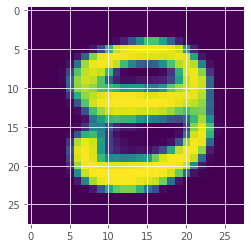

====> Epoch: 51 Average loss: 72.4739
====> Test set loss: KLD Loss = 4.1903, NLL Loss = 67.7066 
Saved model to saves/vrnn_state_dict_51.pth
Train Epoch: 52 [0/60000 (0%)]	 KLD Loss: 4.162011 	 NLL Loss: 67.912216


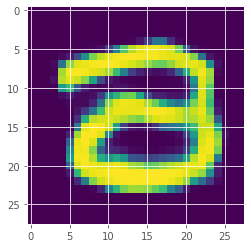

Train Epoch: 52 [2800/60000 (21%)]	 KLD Loss: 4.464608 	 NLL Loss: 68.385742


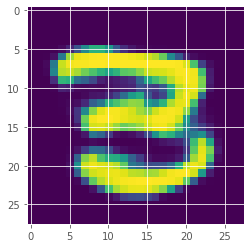

Train Epoch: 52 [5600/60000 (43%)]	 KLD Loss: 4.205246 	 NLL Loss: 68.505547


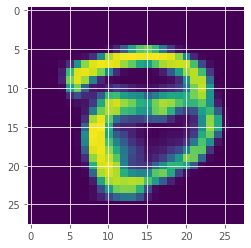

Train Epoch: 52 [8400/60000 (64%)]	 KLD Loss: 4.113221 	 NLL Loss: 68.850632


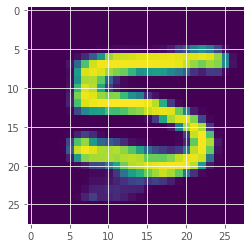

Train Epoch: 52 [11200/60000 (85%)]	 KLD Loss: 4.243382 	 NLL Loss: 66.990730


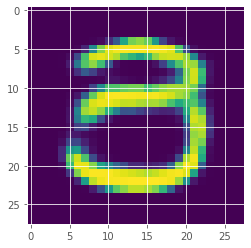

====> Epoch: 52 Average loss: 72.3831
====> Test set loss: KLD Loss = 4.2521, NLL Loss = 68.2053 
Train Epoch: 53 [0/60000 (0%)]	 KLD Loss: 4.560256 	 NLL Loss: 70.361092


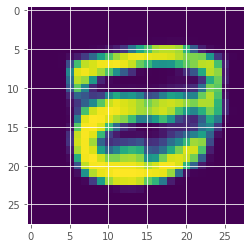

Train Epoch: 53 [2800/60000 (21%)]	 KLD Loss: 4.380605 	 NLL Loss: 69.353249


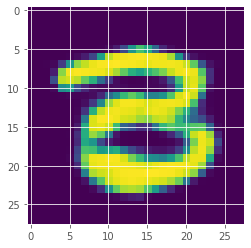

Train Epoch: 53 [5600/60000 (43%)]	 KLD Loss: 4.237421 	 NLL Loss: 68.024719


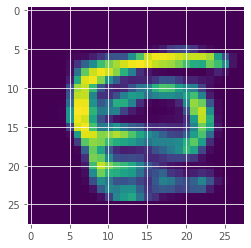

Train Epoch: 53 [8400/60000 (64%)]	 KLD Loss: 4.102437 	 NLL Loss: 66.226196


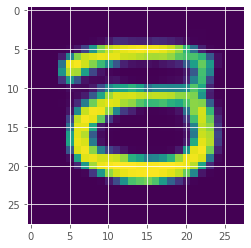

Train Epoch: 53 [11200/60000 (85%)]	 KLD Loss: 4.462782 	 NLL Loss: 73.013855


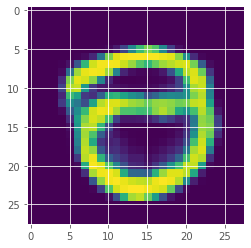

====> Epoch: 53 Average loss: 72.2457
====> Test set loss: KLD Loss = 4.1322, NLL Loss = 68.3613 
Train Epoch: 54 [0/60000 (0%)]	 KLD Loss: 3.977611 	 NLL Loss: 69.397942


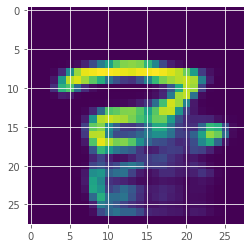

Train Epoch: 54 [2800/60000 (21%)]	 KLD Loss: 4.016581 	 NLL Loss: 70.144875


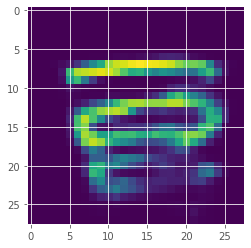

Train Epoch: 54 [5600/60000 (43%)]	 KLD Loss: 4.307404 	 NLL Loss: 68.065880


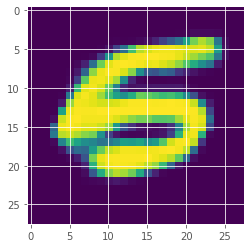

Train Epoch: 54 [8400/60000 (64%)]	 KLD Loss: 4.443100 	 NLL Loss: 70.254112


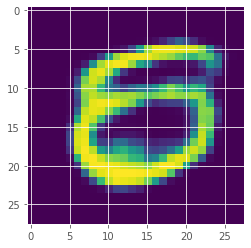

Train Epoch: 54 [11200/60000 (85%)]	 KLD Loss: 3.866861 	 NLL Loss: 66.154594


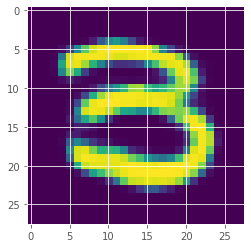

====> Epoch: 54 Average loss: 72.6956
====> Test set loss: KLD Loss = 4.1267, NLL Loss = 67.8772 
Train Epoch: 55 [0/60000 (0%)]	 KLD Loss: 4.003457 	 NLL Loss: 68.213905


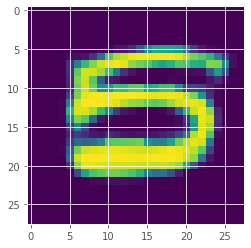

Train Epoch: 55 [2800/60000 (21%)]	 KLD Loss: 3.957172 	 NLL Loss: 68.297226


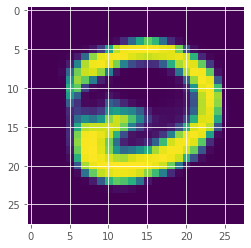

Train Epoch: 55 [5600/60000 (43%)]	 KLD Loss: 3.991604 	 NLL Loss: 70.197044


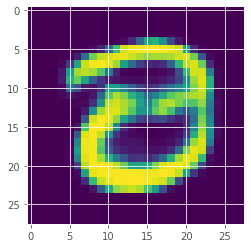

Train Epoch: 55 [8400/60000 (64%)]	 KLD Loss: 4.556348 	 NLL Loss: 71.099594


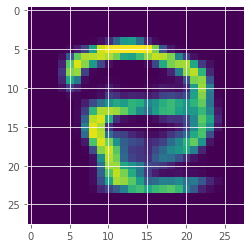

Train Epoch: 55 [11200/60000 (85%)]	 KLD Loss: 4.311642 	 NLL Loss: 71.208359


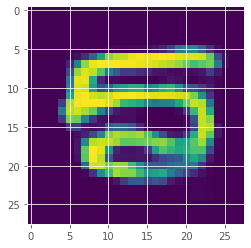

====> Epoch: 55 Average loss: 72.5088
====> Test set loss: KLD Loss = 4.0060, NLL Loss = 68.0758 
Train Epoch: 56 [0/60000 (0%)]	 KLD Loss: 4.092334 	 NLL Loss: 67.135483


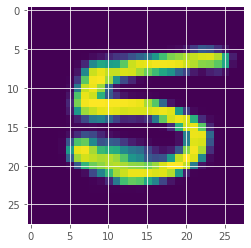

Train Epoch: 56 [2800/60000 (21%)]	 KLD Loss: 4.282660 	 NLL Loss: 65.810127


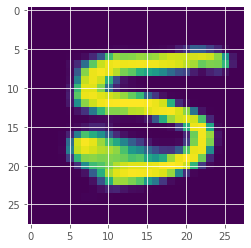

Train Epoch: 56 [5600/60000 (43%)]	 KLD Loss: 4.151643 	 NLL Loss: 66.866028


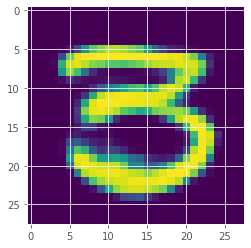

Train Epoch: 56 [8400/60000 (64%)]	 KLD Loss: 4.020187 	 NLL Loss: 68.291321


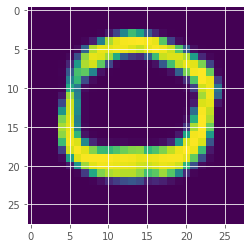

Train Epoch: 56 [11200/60000 (85%)]	 KLD Loss: 4.448003 	 NLL Loss: 70.200577


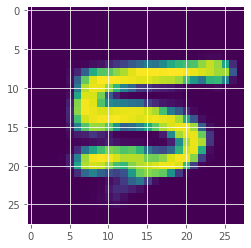

====> Epoch: 56 Average loss: 72.0496
====> Test set loss: KLD Loss = 4.2052, NLL Loss = 67.9101 
Train Epoch: 57 [0/60000 (0%)]	 KLD Loss: 4.407257 	 NLL Loss: 67.283218


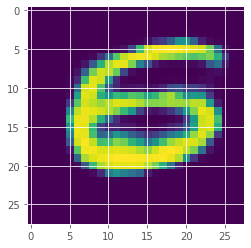

Train Epoch: 57 [2800/60000 (21%)]	 KLD Loss: 3.923033 	 NLL Loss: 69.229439


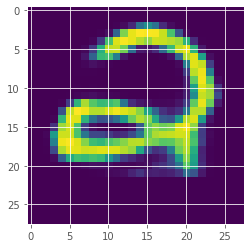

Train Epoch: 57 [5600/60000 (43%)]	 KLD Loss: 4.047307 	 NLL Loss: 67.397285


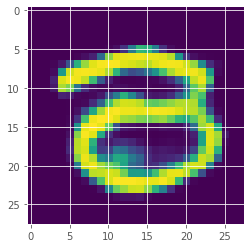

Train Epoch: 57 [8400/60000 (64%)]	 KLD Loss: 3.947482 	 NLL Loss: 66.584793


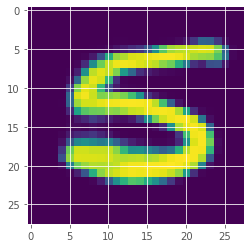

Train Epoch: 57 [11200/60000 (85%)]	 KLD Loss: 4.233696 	 NLL Loss: 67.102150


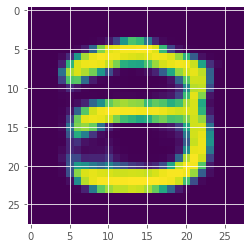

====> Epoch: 57 Average loss: 72.2877
====> Test set loss: KLD Loss = 4.4567, NLL Loss = 72.5768 
Train Epoch: 58 [0/60000 (0%)]	 KLD Loss: 4.456098 	 NLL Loss: 73.966507


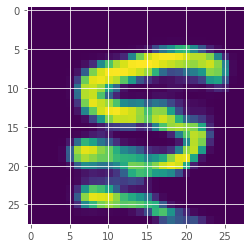

Train Epoch: 58 [2800/60000 (21%)]	 KLD Loss: 4.332485 	 NLL Loss: 70.246559


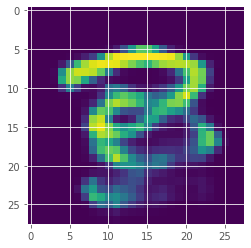

Train Epoch: 58 [5600/60000 (43%)]	 KLD Loss: 3.850633 	 NLL Loss: 67.263344


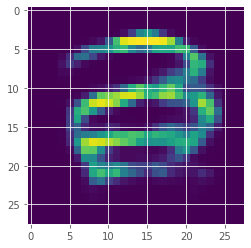

Train Epoch: 58 [8400/60000 (64%)]	 KLD Loss: 4.046419 	 NLL Loss: 69.827888


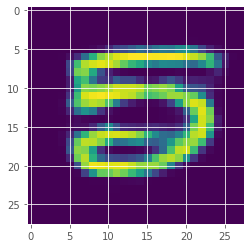

Train Epoch: 58 [11200/60000 (85%)]	 KLD Loss: 4.228101 	 NLL Loss: 68.009529


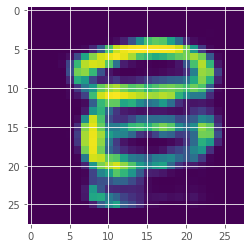

====> Epoch: 58 Average loss: 73.0873
====> Test set loss: KLD Loss = 4.3085, NLL Loss = 67.8232 
Train Epoch: 59 [0/60000 (0%)]	 KLD Loss: 4.147776 	 NLL Loss: 67.638779


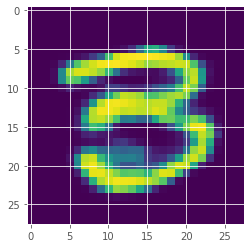

Train Epoch: 59 [2800/60000 (21%)]	 KLD Loss: 4.126763 	 NLL Loss: 68.905098


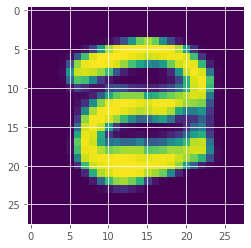

Train Epoch: 59 [5600/60000 (43%)]	 KLD Loss: 4.313142 	 NLL Loss: 71.717033


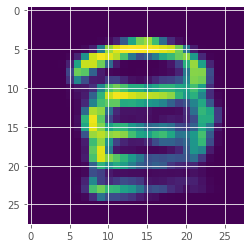

Train Epoch: 59 [8400/60000 (64%)]	 KLD Loss: 3.861545 	 NLL Loss: 66.100822


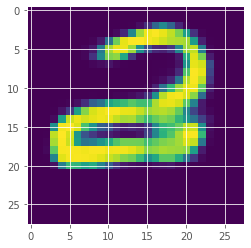

Train Epoch: 59 [11200/60000 (85%)]	 KLD Loss: 4.189911 	 NLL Loss: 66.706261


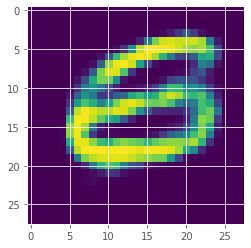

====> Epoch: 59 Average loss: 72.1178
====> Test set loss: KLD Loss = 4.0580, NLL Loss = 67.8112 
Train Epoch: 60 [0/60000 (0%)]	 KLD Loss: 4.357672 	 NLL Loss: 70.370369


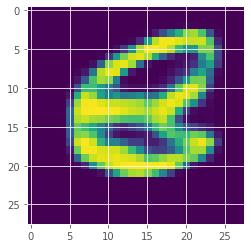

Train Epoch: 60 [2800/60000 (21%)]	 KLD Loss: 3.956770 	 NLL Loss: 63.374550


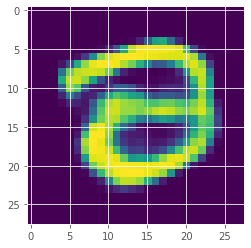

Train Epoch: 60 [5600/60000 (43%)]	 KLD Loss: 4.237291 	 NLL Loss: 64.584335


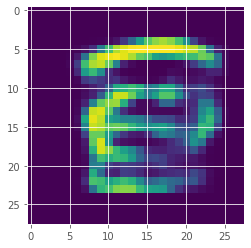

Train Epoch: 60 [8400/60000 (64%)]	 KLD Loss: 4.084010 	 NLL Loss: 66.870537


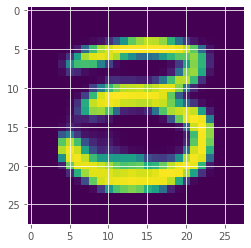

Train Epoch: 60 [11200/60000 (85%)]	 KLD Loss: 4.300212 	 NLL Loss: 70.124275


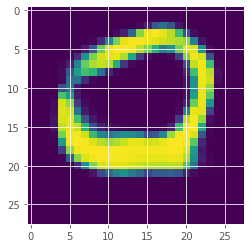

====> Epoch: 60 Average loss: 71.9846
====> Test set loss: KLD Loss = 4.1285, NLL Loss = 67.6175 
Train Epoch: 61 [0/60000 (0%)]	 KLD Loss: 4.302738 	 NLL Loss: 70.419212


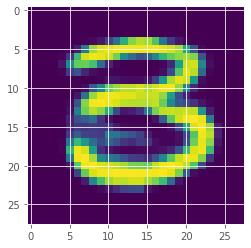

Train Epoch: 61 [2800/60000 (21%)]	 KLD Loss: 4.172770 	 NLL Loss: 68.171509


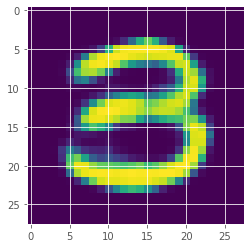

Train Epoch: 61 [5600/60000 (43%)]	 KLD Loss: 3.995489 	 NLL Loss: 66.020317


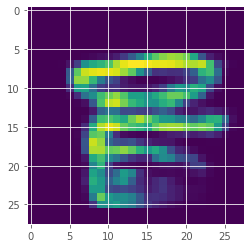

Train Epoch: 61 [8400/60000 (64%)]	 KLD Loss: 4.117598 	 NLL Loss: 67.658592


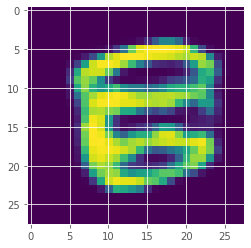

Train Epoch: 61 [11200/60000 (85%)]	 KLD Loss: 4.327390 	 NLL Loss: 66.014679


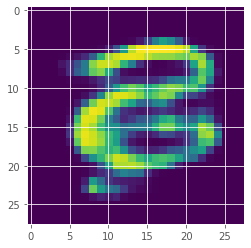

====> Epoch: 61 Average loss: 72.2169
====> Test set loss: KLD Loss = 4.2041, NLL Loss = 67.5575 
Saved model to saves/vrnn_state_dict_61.pth
Train Epoch: 62 [0/60000 (0%)]	 KLD Loss: 4.208149 	 NLL Loss: 72.519859


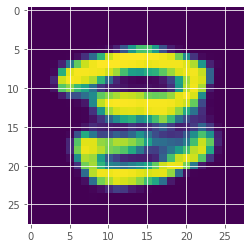

Train Epoch: 62 [2800/60000 (21%)]	 KLD Loss: 4.057931 	 NLL Loss: 71.498093


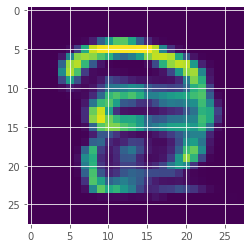

Train Epoch: 62 [5600/60000 (43%)]	 KLD Loss: 4.403990 	 NLL Loss: 68.673271


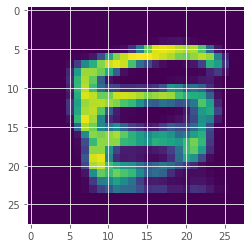

Train Epoch: 62 [8400/60000 (64%)]	 KLD Loss: 4.055399 	 NLL Loss: 68.474579


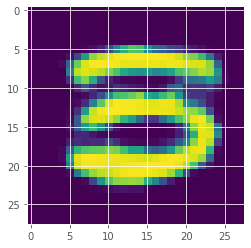

Train Epoch: 62 [11200/60000 (85%)]	 KLD Loss: 4.454636 	 NLL Loss: 67.365494


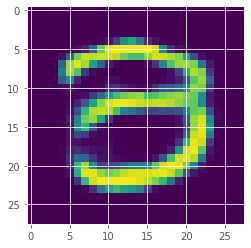

====> Epoch: 62 Average loss: 71.8419
====> Test set loss: KLD Loss = 4.1440, NLL Loss = 67.6854 
Train Epoch: 63 [0/60000 (0%)]	 KLD Loss: 4.065205 	 NLL Loss: 68.536713


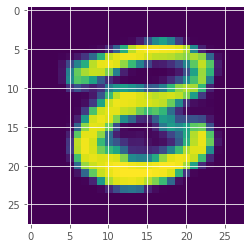

Train Epoch: 63 [2800/60000 (21%)]	 KLD Loss: 4.121139 	 NLL Loss: 67.580818


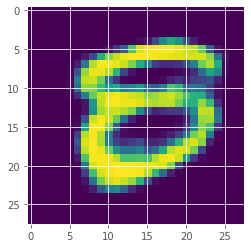

Train Epoch: 63 [5600/60000 (43%)]	 KLD Loss: 4.257846 	 NLL Loss: 70.496010


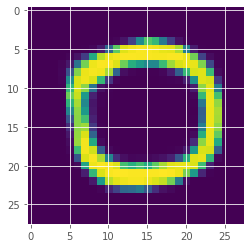

Train Epoch: 63 [8400/60000 (64%)]	 KLD Loss: 4.006995 	 NLL Loss: 66.441727


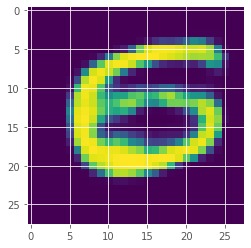

Train Epoch: 63 [11200/60000 (85%)]	 KLD Loss: 4.385715 	 NLL Loss: 67.689346


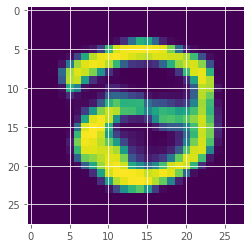

====> Epoch: 63 Average loss: 71.9133
====> Test set loss: KLD Loss = 4.1109, NLL Loss = 67.7348 
Train Epoch: 64 [0/60000 (0%)]	 KLD Loss: 3.952241 	 NLL Loss: 68.300087


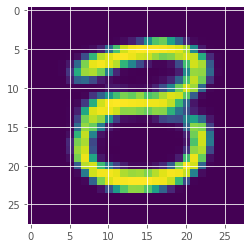

Train Epoch: 64 [2800/60000 (21%)]	 KLD Loss: 4.706951 	 NLL Loss: 70.793320


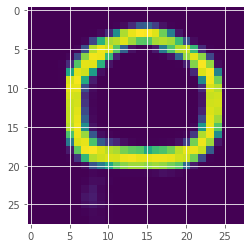

Train Epoch: 64 [5600/60000 (43%)]	 KLD Loss: 4.041783 	 NLL Loss: 67.433434


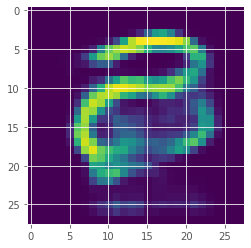

Train Epoch: 64 [8400/60000 (64%)]	 KLD Loss: 4.034087 	 NLL Loss: 70.175095


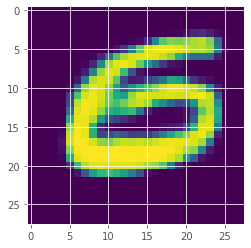

Train Epoch: 64 [11200/60000 (85%)]	 KLD Loss: 4.163987 	 NLL Loss: 66.898972


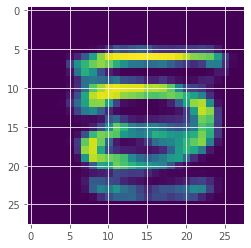

====> Epoch: 64 Average loss: 72.8211
====> Test set loss: KLD Loss = 4.0409, NLL Loss = 67.8136 
Train Epoch: 65 [0/60000 (0%)]	 KLD Loss: 4.076555 	 NLL Loss: 65.024734


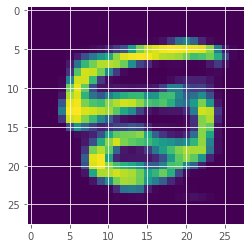

Train Epoch: 65 [2800/60000 (21%)]	 KLD Loss: 3.981318 	 NLL Loss: 66.295029


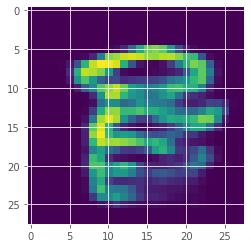

Train Epoch: 65 [5600/60000 (43%)]	 KLD Loss: 4.265241 	 NLL Loss: 66.886833


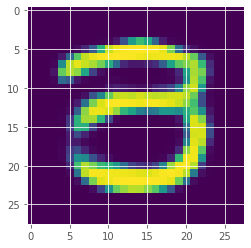

Train Epoch: 65 [8400/60000 (64%)]	 KLD Loss: 4.061784 	 NLL Loss: 69.130798


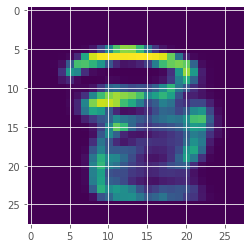

Train Epoch: 65 [11200/60000 (85%)]	 KLD Loss: 3.866358 	 NLL Loss: 69.237724


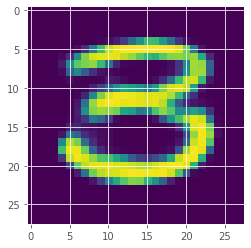

====> Epoch: 65 Average loss: 72.0032
====> Test set loss: KLD Loss = 4.1828, NLL Loss = 67.6236 
Train Epoch: 66 [0/60000 (0%)]	 KLD Loss: 4.092384 	 NLL Loss: 66.410828


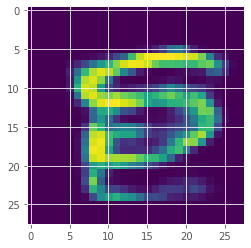

Train Epoch: 66 [2800/60000 (21%)]	 KLD Loss: 4.017942 	 NLL Loss: 65.074913


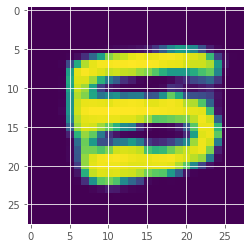

Train Epoch: 66 [5600/60000 (43%)]	 KLD Loss: 4.370767 	 NLL Loss: 68.510895


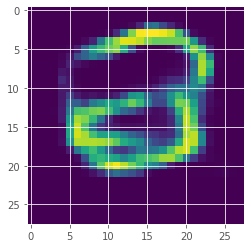

Train Epoch: 66 [8400/60000 (64%)]	 KLD Loss: 4.081409 	 NLL Loss: 67.110260


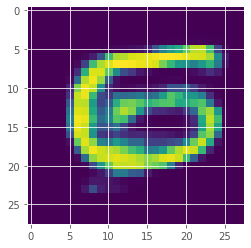

Train Epoch: 66 [11200/60000 (85%)]	 KLD Loss: 4.125541 	 NLL Loss: 65.911461


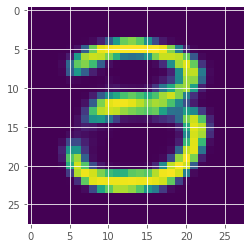

====> Epoch: 66 Average loss: 71.7292
====> Test set loss: KLD Loss = 4.0897, NLL Loss = 68.1098 
Train Epoch: 67 [0/60000 (0%)]	 KLD Loss: 4.026746 	 NLL Loss: 66.896111


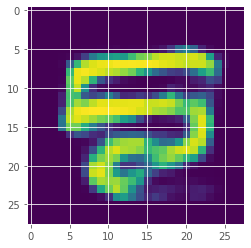

Train Epoch: 67 [2800/60000 (21%)]	 KLD Loss: 4.260230 	 NLL Loss: 64.874649


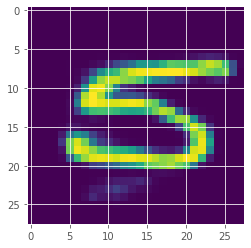

Train Epoch: 67 [5600/60000 (43%)]	 KLD Loss: 4.075935 	 NLL Loss: 68.084747


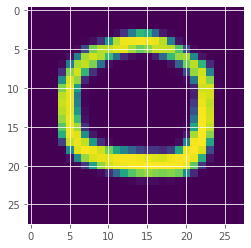

Train Epoch: 67 [8400/60000 (64%)]	 KLD Loss: 3.943983 	 NLL Loss: 67.851112


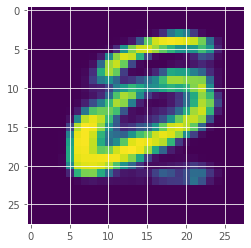

Train Epoch: 67 [11200/60000 (85%)]	 KLD Loss: 4.071853 	 NLL Loss: 66.793983


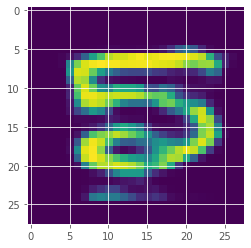

====> Epoch: 67 Average loss: 71.7021
====> Test set loss: KLD Loss = 3.9795, NLL Loss = 67.5079 
Train Epoch: 68 [0/60000 (0%)]	 KLD Loss: 3.902851 	 NLL Loss: 69.653130


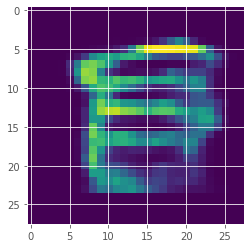

Train Epoch: 68 [2800/60000 (21%)]	 KLD Loss: 4.337426 	 NLL Loss: 69.479660


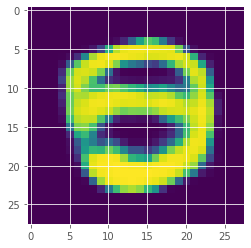

Train Epoch: 68 [5600/60000 (43%)]	 KLD Loss: 4.192479 	 NLL Loss: 68.453888


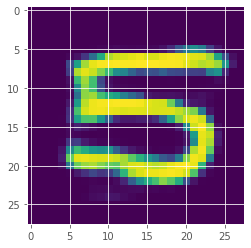

Train Epoch: 68 [8400/60000 (64%)]	 KLD Loss: 4.568440 	 NLL Loss: 69.548080


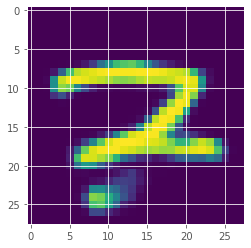

Train Epoch: 68 [11200/60000 (85%)]	 KLD Loss: 4.398589 	 NLL Loss: 69.117073


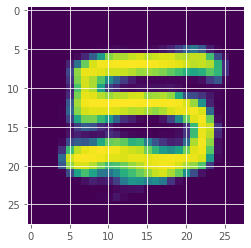

====> Epoch: 68 Average loss: 71.8173
====> Test set loss: KLD Loss = 4.1885, NLL Loss = 67.4070 
Train Epoch: 69 [0/60000 (0%)]	 KLD Loss: 4.159163 	 NLL Loss: 67.545120


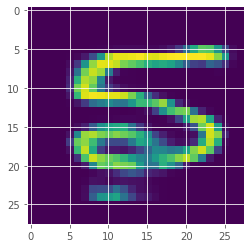

Train Epoch: 69 [2800/60000 (21%)]	 KLD Loss: 4.198053 	 NLL Loss: 67.191322


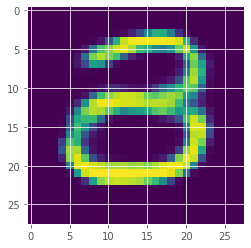

Train Epoch: 69 [5600/60000 (43%)]	 KLD Loss: 4.174620 	 NLL Loss: 68.396782


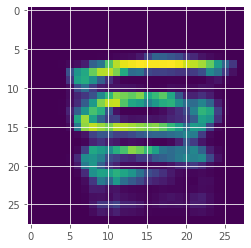

Train Epoch: 69 [8400/60000 (64%)]	 KLD Loss: 4.215248 	 NLL Loss: 65.792953


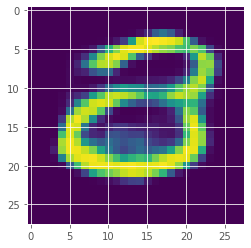

Train Epoch: 69 [11200/60000 (85%)]	 KLD Loss: 4.206251 	 NLL Loss: 66.947472


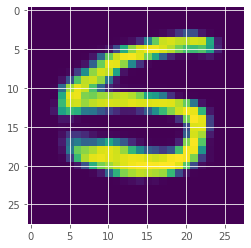

====> Epoch: 69 Average loss: 71.8487
====> Test set loss: KLD Loss = 4.2280, NLL Loss = 67.6349 
Train Epoch: 70 [0/60000 (0%)]	 KLD Loss: 4.215652 	 NLL Loss: 65.210625


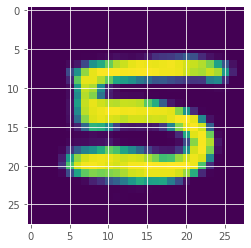

Train Epoch: 70 [2800/60000 (21%)]	 KLD Loss: 4.063345 	 NLL Loss: 68.202568


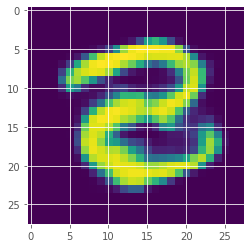

Train Epoch: 70 [5600/60000 (43%)]	 KLD Loss: 4.168046 	 NLL Loss: 68.410889


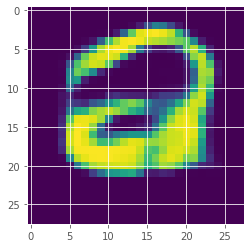

Train Epoch: 70 [8400/60000 (64%)]	 KLD Loss: 4.370943 	 NLL Loss: 68.644890


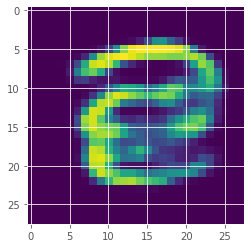

Train Epoch: 70 [11200/60000 (85%)]	 KLD Loss: 4.178986 	 NLL Loss: 69.298737


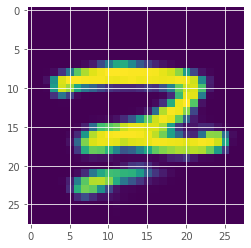

====> Epoch: 70 Average loss: 71.5814
====> Test set loss: KLD Loss = 4.1274, NLL Loss = 67.4251 
Train Epoch: 71 [0/60000 (0%)]	 KLD Loss: 4.244164 	 NLL Loss: 66.936356


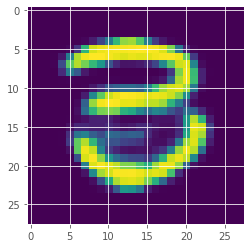

Train Epoch: 71 [2800/60000 (21%)]	 KLD Loss: 4.034884 	 NLL Loss: 67.032181


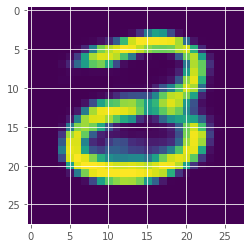

Train Epoch: 71 [5600/60000 (43%)]	 KLD Loss: 4.238915 	 NLL Loss: 71.589005


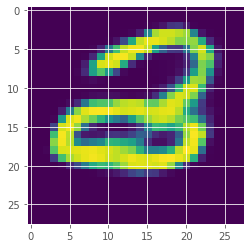

Train Epoch: 71 [8400/60000 (64%)]	 KLD Loss: 3.763020 	 NLL Loss: 67.665199


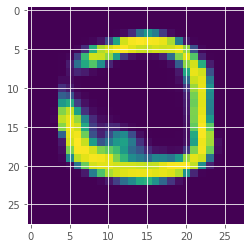

Train Epoch: 71 [11200/60000 (85%)]	 KLD Loss: 4.555724 	 NLL Loss: 69.951630


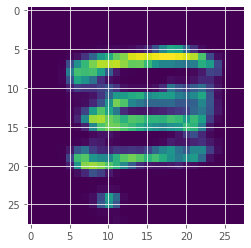

====> Epoch: 71 Average loss: 71.8139
====> Test set loss: KLD Loss = 4.0041, NLL Loss = 67.8462 
Saved model to saves/vrnn_state_dict_71.pth
Train Epoch: 72 [0/60000 (0%)]	 KLD Loss: 4.020467 	 NLL Loss: 66.769951


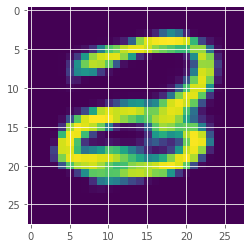

Train Epoch: 72 [2800/60000 (21%)]	 KLD Loss: 4.326948 	 NLL Loss: 69.308617


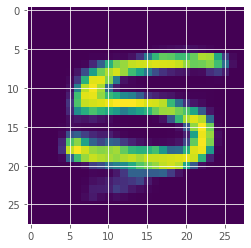

Train Epoch: 72 [5600/60000 (43%)]	 KLD Loss: 4.060699 	 NLL Loss: 67.781044


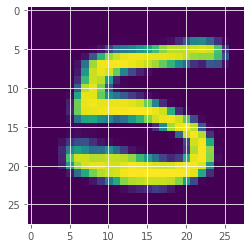

Train Epoch: 72 [8400/60000 (64%)]	 KLD Loss: 3.985390 	 NLL Loss: 68.285210


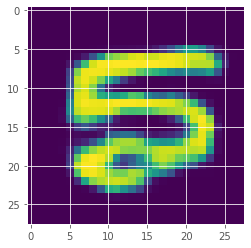

Train Epoch: 72 [11200/60000 (85%)]	 KLD Loss: 4.049101 	 NLL Loss: 65.926994


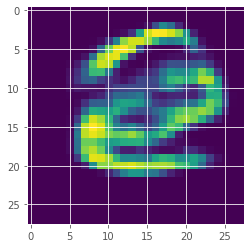

====> Epoch: 72 Average loss: 71.6567
====> Test set loss: KLD Loss = 4.0845, NLL Loss = 67.3761 
Train Epoch: 73 [0/60000 (0%)]	 KLD Loss: 4.214410 	 NLL Loss: 66.794647


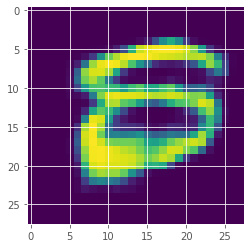

Train Epoch: 73 [2800/60000 (21%)]	 KLD Loss: 4.166834 	 NLL Loss: 66.611801


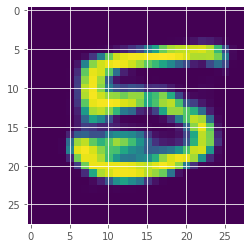

Train Epoch: 73 [5600/60000 (43%)]	 KLD Loss: 4.107712 	 NLL Loss: 67.604019


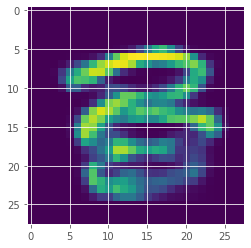

Train Epoch: 73 [8400/60000 (64%)]	 KLD Loss: 3.850599 	 NLL Loss: 66.300537


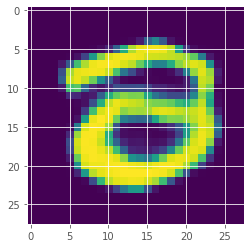

Train Epoch: 73 [11200/60000 (85%)]	 KLD Loss: 4.160273 	 NLL Loss: 68.435783


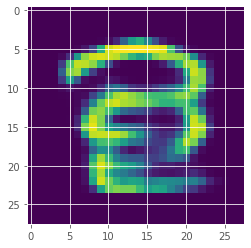

====> Epoch: 73 Average loss: 71.5071
====> Test set loss: KLD Loss = 4.0421, NLL Loss = 67.4939 
Train Epoch: 74 [0/60000 (0%)]	 KLD Loss: 4.195750 	 NLL Loss: 67.761200


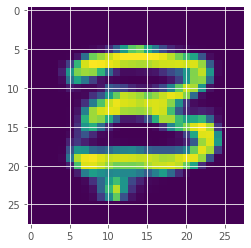

Train Epoch: 74 [2800/60000 (21%)]	 KLD Loss: 4.050065 	 NLL Loss: 66.658592


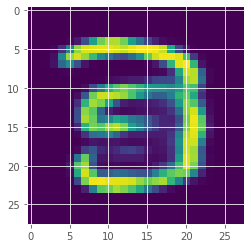

Train Epoch: 74 [5600/60000 (43%)]	 KLD Loss: 4.283115 	 NLL Loss: 66.924706


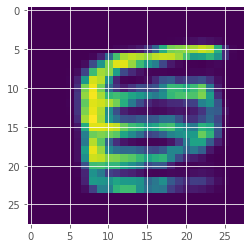

Train Epoch: 74 [8400/60000 (64%)]	 KLD Loss: 4.245950 	 NLL Loss: 64.756912


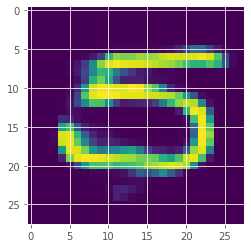

Train Epoch: 74 [11200/60000 (85%)]	 KLD Loss: 4.098491 	 NLL Loss: 68.492905


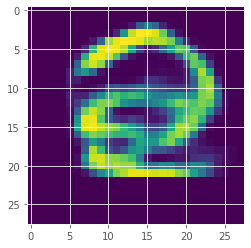

====> Epoch: 74 Average loss: 71.4650
====> Test set loss: KLD Loss = 4.2375, NLL Loss = 67.0908 
Train Epoch: 75 [0/60000 (0%)]	 KLD Loss: 4.459686 	 NLL Loss: 67.584435


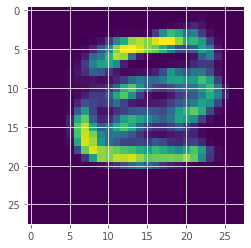

Train Epoch: 75 [2800/60000 (21%)]	 KLD Loss: 4.064789 	 NLL Loss: 67.849388


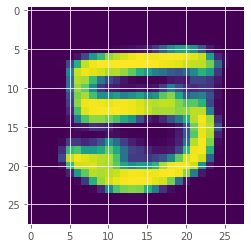

Train Epoch: 75 [5600/60000 (43%)]	 KLD Loss: 4.324408 	 NLL Loss: 65.716629


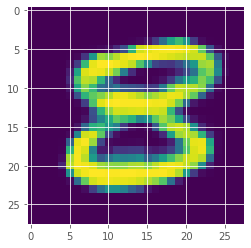

Train Epoch: 75 [8400/60000 (64%)]	 KLD Loss: 4.247066 	 NLL Loss: 68.442078


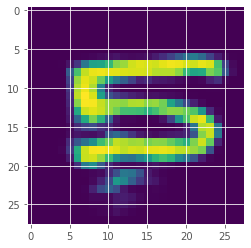

Train Epoch: 75 [11200/60000 (85%)]	 KLD Loss: 3.938673 	 NLL Loss: 65.079414


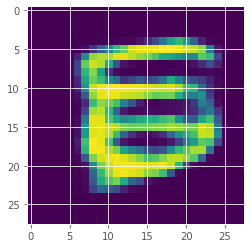

====> Epoch: 75 Average loss: 71.7507
====> Test set loss: KLD Loss = 4.2259, NLL Loss = 67.2524 
Train Epoch: 76 [0/60000 (0%)]	 KLD Loss: 4.330557 	 NLL Loss: 69.173981


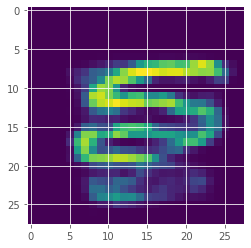

Train Epoch: 76 [2800/60000 (21%)]	 KLD Loss: 4.038377 	 NLL Loss: 68.391159


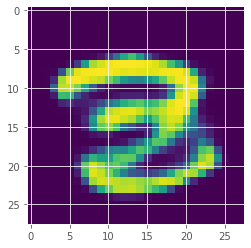

Train Epoch: 76 [5600/60000 (43%)]	 KLD Loss: 3.891361 	 NLL Loss: 65.667854


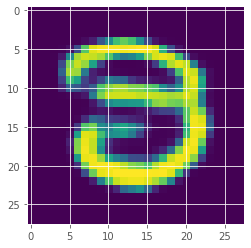

Train Epoch: 76 [8400/60000 (64%)]	 KLD Loss: 4.103441 	 NLL Loss: 69.810379


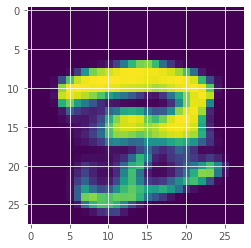

Train Epoch: 76 [11200/60000 (85%)]	 KLD Loss: 4.177941 	 NLL Loss: 67.978462


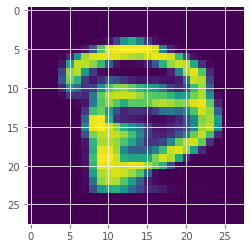

====> Epoch: 76 Average loss: 71.4611
====> Test set loss: KLD Loss = 4.1795, NLL Loss = 67.5041 
Train Epoch: 77 [0/60000 (0%)]	 KLD Loss: 4.252723 	 NLL Loss: 67.127228


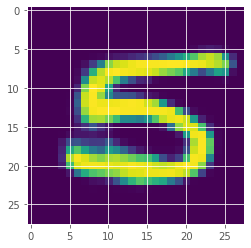

Train Epoch: 77 [2800/60000 (21%)]	 KLD Loss: 4.459542 	 NLL Loss: 68.945328


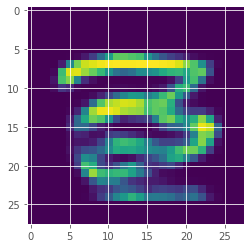

Train Epoch: 77 [5600/60000 (43%)]	 KLD Loss: 4.302328 	 NLL Loss: 68.225693


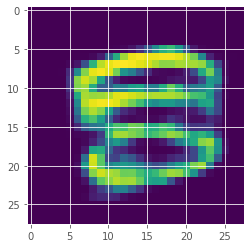

Train Epoch: 77 [8400/60000 (64%)]	 KLD Loss: 4.241807 	 NLL Loss: 69.503693


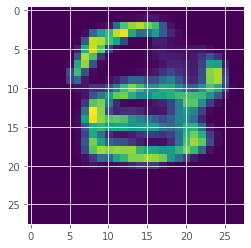

Train Epoch: 77 [11200/60000 (85%)]	 KLD Loss: 4.230363 	 NLL Loss: 73.291519


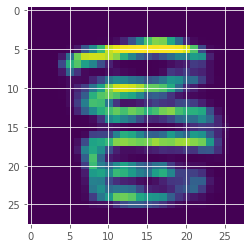

====> Epoch: 77 Average loss: 71.7074
====> Test set loss: KLD Loss = 4.2132, NLL Loss = 67.4453 
Train Epoch: 78 [0/60000 (0%)]	 KLD Loss: 4.307112 	 NLL Loss: 66.785408


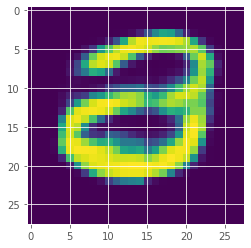

Train Epoch: 78 [2800/60000 (21%)]	 KLD Loss: 4.141457 	 NLL Loss: 70.004417


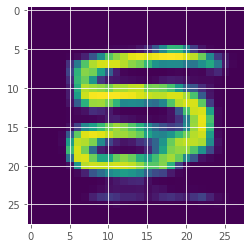

Train Epoch: 78 [5600/60000 (43%)]	 KLD Loss: 4.400574 	 NLL Loss: 69.592102


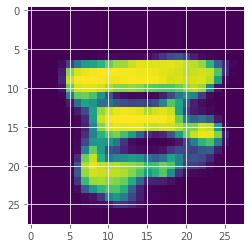

Train Epoch: 78 [8400/60000 (64%)]	 KLD Loss: 3.932431 	 NLL Loss: 67.129913


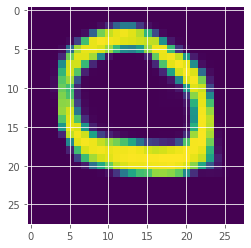

Train Epoch: 78 [11200/60000 (85%)]	 KLD Loss: 3.973542 	 NLL Loss: 64.181786


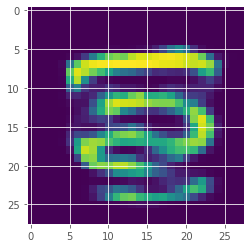

====> Epoch: 78 Average loss: 71.4120
====> Test set loss: KLD Loss = 4.4040, NLL Loss = 66.9701 
Train Epoch: 79 [0/60000 (0%)]	 KLD Loss: 4.682076 	 NLL Loss: 65.520294


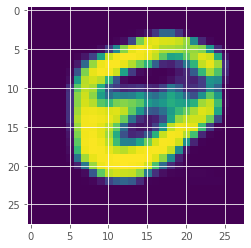

Train Epoch: 79 [2800/60000 (21%)]	 KLD Loss: 4.088376 	 NLL Loss: 65.237679


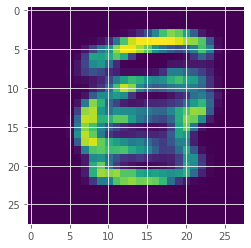

Train Epoch: 79 [5600/60000 (43%)]	 KLD Loss: 4.233030 	 NLL Loss: 66.026817


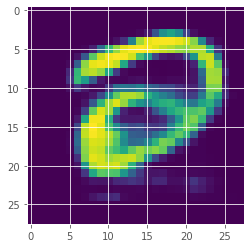

Train Epoch: 79 [8400/60000 (64%)]	 KLD Loss: 4.134730 	 NLL Loss: 65.245888


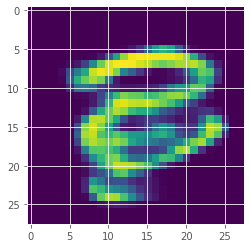

Train Epoch: 79 [11200/60000 (85%)]	 KLD Loss: 4.241238 	 NLL Loss: 68.730400


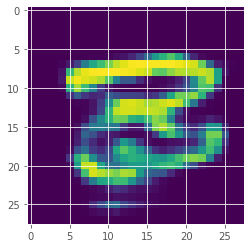

====> Epoch: 79 Average loss: 71.7647
====> Test set loss: KLD Loss = 4.1810, NLL Loss = 67.0647 
Train Epoch: 80 [0/60000 (0%)]	 KLD Loss: 4.141815 	 NLL Loss: 67.320816


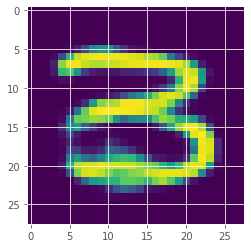

Train Epoch: 80 [2800/60000 (21%)]	 KLD Loss: 4.086305 	 NLL Loss: 66.014359


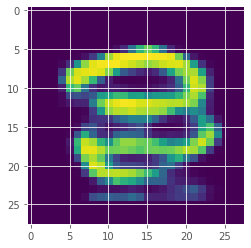

Train Epoch: 80 [5600/60000 (43%)]	 KLD Loss: 4.275543 	 NLL Loss: 65.228264


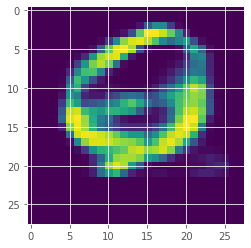

Train Epoch: 80 [8400/60000 (64%)]	 KLD Loss: 4.115481 	 NLL Loss: 66.475380


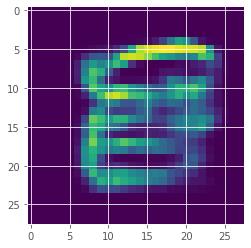

Train Epoch: 80 [11200/60000 (85%)]	 KLD Loss: 3.995800 	 NLL Loss: 66.068787


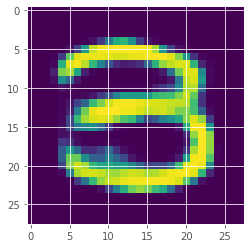

====> Epoch: 80 Average loss: 71.3485
====> Test set loss: KLD Loss = 4.2680, NLL Loss = 67.2175 
Train Epoch: 81 [0/60000 (0%)]	 KLD Loss: 4.185824 	 NLL Loss: 66.068649


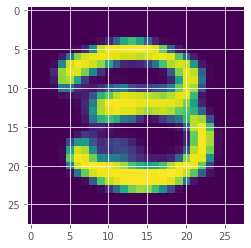

Train Epoch: 81 [2800/60000 (21%)]	 KLD Loss: 4.028367 	 NLL Loss: 68.444550


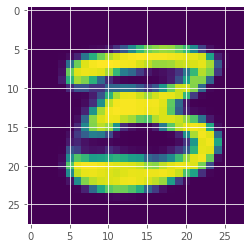

Train Epoch: 81 [5600/60000 (43%)]	 KLD Loss: 3.984933 	 NLL Loss: 67.248116


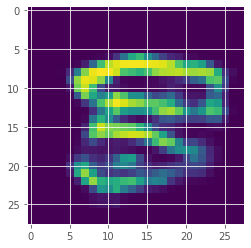

Train Epoch: 81 [8400/60000 (64%)]	 KLD Loss: 4.241658 	 NLL Loss: 69.814964


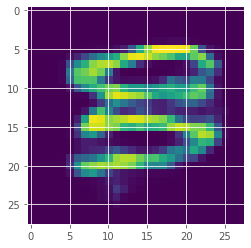

Train Epoch: 81 [11200/60000 (85%)]	 KLD Loss: 4.080064 	 NLL Loss: 65.970596


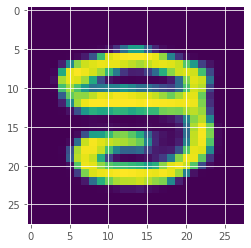

====> Epoch: 81 Average loss: 71.4458
====> Test set loss: KLD Loss = 4.2041, NLL Loss = 67.1989 
Saved model to saves/vrnn_state_dict_81.pth
Train Epoch: 82 [0/60000 (0%)]	 KLD Loss: 3.946357 	 NLL Loss: 68.073822


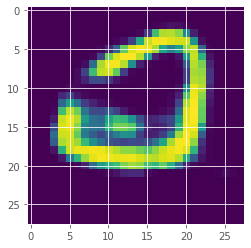

Train Epoch: 82 [2800/60000 (21%)]	 KLD Loss: 3.980412 	 NLL Loss: 67.506485


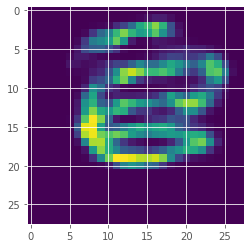

Train Epoch: 82 [5600/60000 (43%)]	 KLD Loss: 4.128342 	 NLL Loss: 66.426453


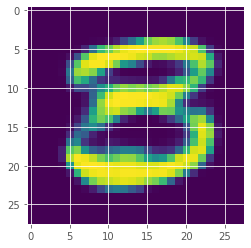

Train Epoch: 82 [8400/60000 (64%)]	 KLD Loss: 3.682259 	 NLL Loss: 67.705414


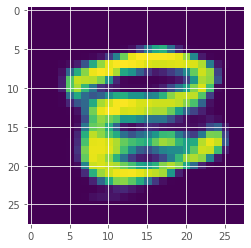

Train Epoch: 82 [11200/60000 (85%)]	 KLD Loss: 4.078420 	 NLL Loss: 66.967995


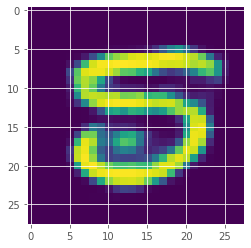

====> Epoch: 82 Average loss: 71.3100
====> Test set loss: KLD Loss = 4.1058, NLL Loss = 67.2880 
Train Epoch: 83 [0/60000 (0%)]	 KLD Loss: 4.191011 	 NLL Loss: 67.380806


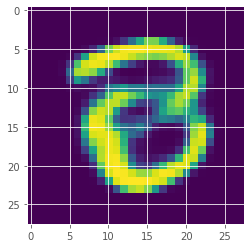

Train Epoch: 83 [2800/60000 (21%)]	 KLD Loss: 4.472444 	 NLL Loss: 68.373611


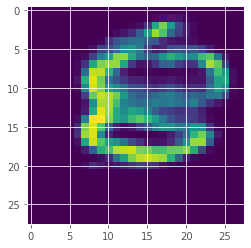

Train Epoch: 83 [5600/60000 (43%)]	 KLD Loss: 4.460185 	 NLL Loss: 69.455826


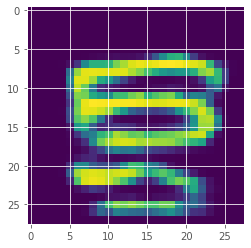

Train Epoch: 83 [8400/60000 (64%)]	 KLD Loss: 4.411715 	 NLL Loss: 69.216316


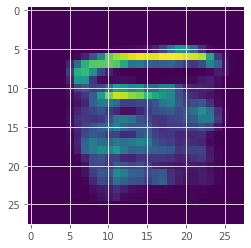

Train Epoch: 83 [11200/60000 (85%)]	 KLD Loss: 3.749343 	 NLL Loss: 65.883255


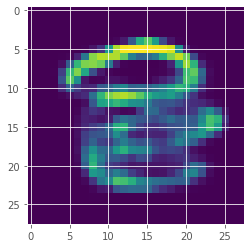

====> Epoch: 83 Average loss: 71.8121
====> Test set loss: KLD Loss = 4.1176, NLL Loss = 67.2224 
Train Epoch: 84 [0/60000 (0%)]	 KLD Loss: 3.853702 	 NLL Loss: 66.674820


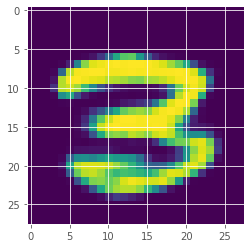

Train Epoch: 84 [2800/60000 (21%)]	 KLD Loss: 4.033048 	 NLL Loss: 66.546066


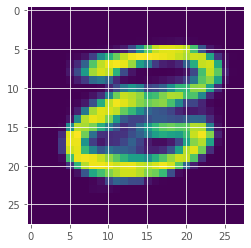

Train Epoch: 84 [5600/60000 (43%)]	 KLD Loss: 3.956272 	 NLL Loss: 65.523331


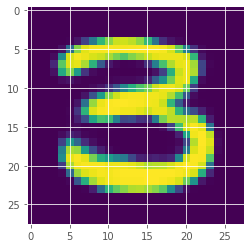

Train Epoch: 84 [8400/60000 (64%)]	 KLD Loss: 3.928568 	 NLL Loss: 65.921143


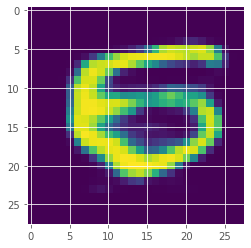

Train Epoch: 84 [11200/60000 (85%)]	 KLD Loss: 4.146625 	 NLL Loss: 67.242096


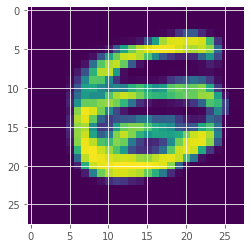

====> Epoch: 84 Average loss: 71.2657
====> Test set loss: KLD Loss = 4.0349, NLL Loss = 67.2596 
Train Epoch: 85 [0/60000 (0%)]	 KLD Loss: 3.956263 	 NLL Loss: 66.268661


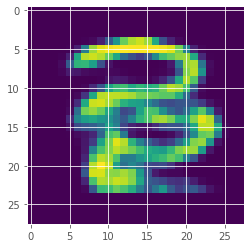

Train Epoch: 85 [2800/60000 (21%)]	 KLD Loss: 4.197369 	 NLL Loss: 67.518974


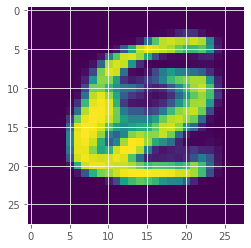

Train Epoch: 85 [5600/60000 (43%)]	 KLD Loss: 4.224109 	 NLL Loss: 66.122726


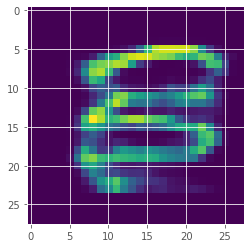

Train Epoch: 85 [8400/60000 (64%)]	 KLD Loss: 3.899059 	 NLL Loss: 67.301727


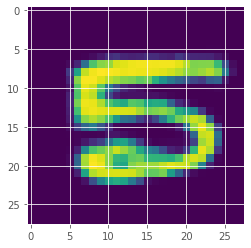

Train Epoch: 85 [11200/60000 (85%)]	 KLD Loss: 3.867263 	 NLL Loss: 62.478420


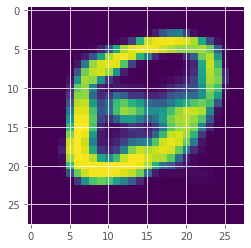

====> Epoch: 85 Average loss: 71.2491
====> Test set loss: KLD Loss = 4.1390, NLL Loss = 67.0971 
Train Epoch: 86 [0/60000 (0%)]	 KLD Loss: 4.141842 	 NLL Loss: 63.869095


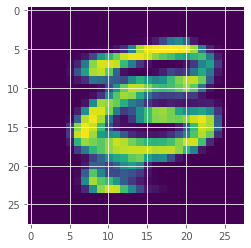

Train Epoch: 86 [2800/60000 (21%)]	 KLD Loss: 4.103069 	 NLL Loss: 69.389008


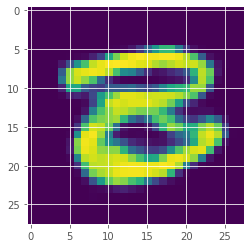

Train Epoch: 86 [5600/60000 (43%)]	 KLD Loss: 4.175002 	 NLL Loss: 65.080887


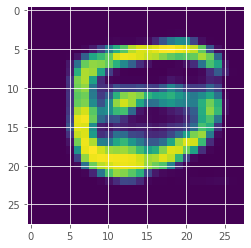

Train Epoch: 86 [8400/60000 (64%)]	 KLD Loss: 3.866789 	 NLL Loss: 65.330704


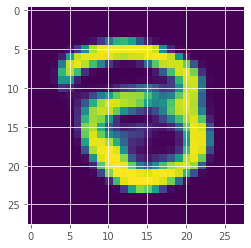

Train Epoch: 86 [11200/60000 (85%)]	 KLD Loss: 4.694601 	 NLL Loss: 73.920509


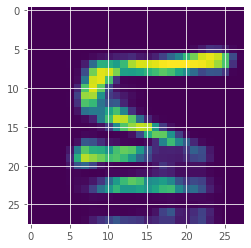

====> Epoch: 86 Average loss: 71.8328
====> Test set loss: KLD Loss = 4.0916, NLL Loss = 68.4306 
Train Epoch: 87 [0/60000 (0%)]	 KLD Loss: 4.198450 	 NLL Loss: 67.051697


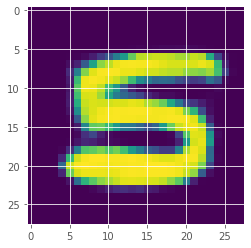

Train Epoch: 87 [2800/60000 (21%)]	 KLD Loss: 4.208287 	 NLL Loss: 68.014938


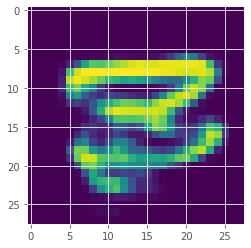

Train Epoch: 87 [5600/60000 (43%)]	 KLD Loss: 4.074762 	 NLL Loss: 68.866699


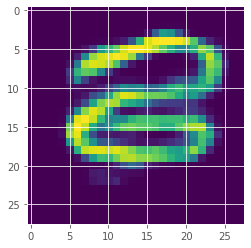

Train Epoch: 87 [8400/60000 (64%)]	 KLD Loss: 4.126590 	 NLL Loss: 65.730103


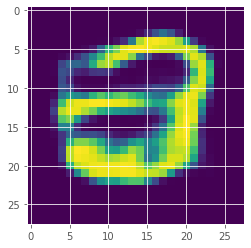

Train Epoch: 87 [11200/60000 (85%)]	 KLD Loss: 4.259754 	 NLL Loss: 69.411674


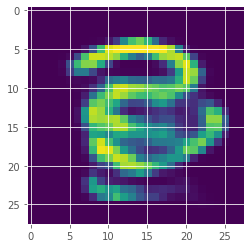

====> Epoch: 87 Average loss: 71.7040
====> Test set loss: KLD Loss = 4.0899, NLL Loss = 67.5059 
Train Epoch: 88 [0/60000 (0%)]	 KLD Loss: 4.021971 	 NLL Loss: 68.928299


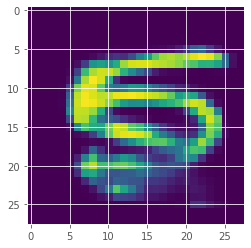

Train Epoch: 88 [2800/60000 (21%)]	 KLD Loss: 4.330217 	 NLL Loss: 69.835846


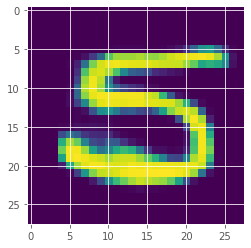

Train Epoch: 88 [5600/60000 (43%)]	 KLD Loss: 3.928732 	 NLL Loss: 66.453041


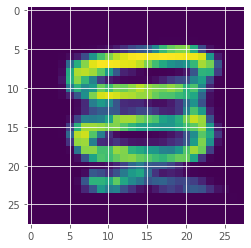

Train Epoch: 88 [8400/60000 (64%)]	 KLD Loss: 4.121531 	 NLL Loss: 66.717155


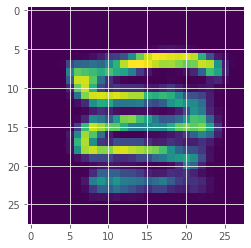

Train Epoch: 88 [11200/60000 (85%)]	 KLD Loss: 4.358825 	 NLL Loss: 69.098366


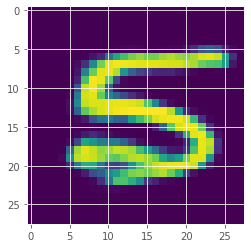

====> Epoch: 88 Average loss: 71.2206
====> Test set loss: KLD Loss = 4.1498, NLL Loss = 66.9235 
Train Epoch: 89 [0/60000 (0%)]	 KLD Loss: 4.045024 	 NLL Loss: 67.008430


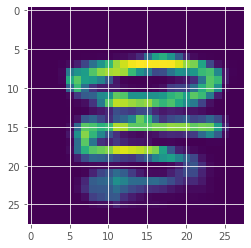

Train Epoch: 89 [2800/60000 (21%)]	 KLD Loss: 4.283408 	 NLL Loss: 68.203003


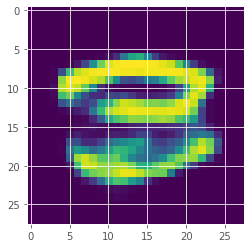

Train Epoch: 89 [5600/60000 (43%)]	 KLD Loss: 4.211587 	 NLL Loss: 65.062111


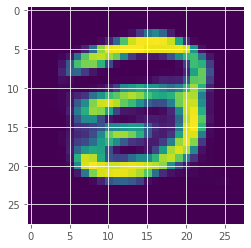

Train Epoch: 89 [8400/60000 (64%)]	 KLD Loss: 3.720339 	 NLL Loss: 64.494629


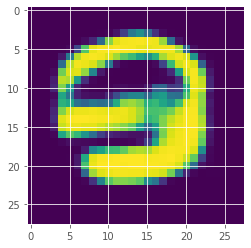

Train Epoch: 89 [11200/60000 (85%)]	 KLD Loss: 4.362283 	 NLL Loss: 66.650841


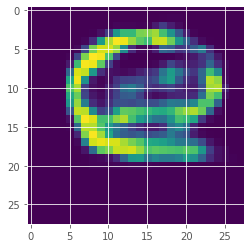

====> Epoch: 89 Average loss: 71.1733
====> Test set loss: KLD Loss = 4.0811, NLL Loss = 67.0631 
Train Epoch: 90 [0/60000 (0%)]	 KLD Loss: 4.283353 	 NLL Loss: 66.854622


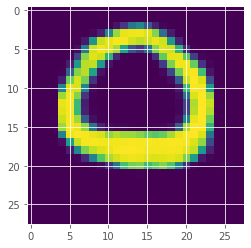

Train Epoch: 90 [2800/60000 (21%)]	 KLD Loss: 4.948092 	 NLL Loss: 72.214119


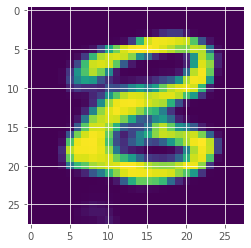

Train Epoch: 90 [5600/60000 (43%)]	 KLD Loss: 4.073198 	 NLL Loss: 68.376999


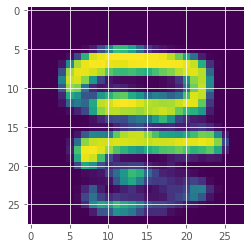

Train Epoch: 90 [8400/60000 (64%)]	 KLD Loss: 4.140098 	 NLL Loss: 68.975128


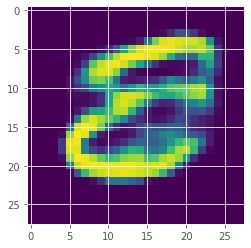

Train Epoch: 90 [11200/60000 (85%)]	 KLD Loss: 4.077230 	 NLL Loss: 66.377647


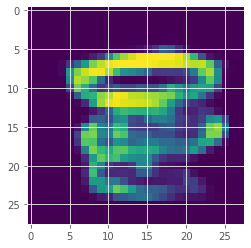

====> Epoch: 90 Average loss: 72.4169
====> Test set loss: KLD Loss = 4.2641, NLL Loss = 67.2460 
Train Epoch: 91 [0/60000 (0%)]	 KLD Loss: 4.281223 	 NLL Loss: 67.909111


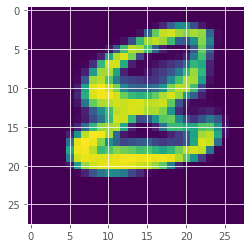

Train Epoch: 91 [2800/60000 (21%)]	 KLD Loss: 4.245124 	 NLL Loss: 65.284012


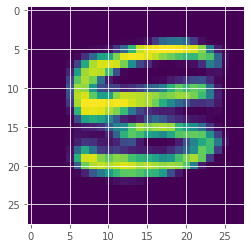

Train Epoch: 91 [5600/60000 (43%)]	 KLD Loss: 4.032724 	 NLL Loss: 68.306381


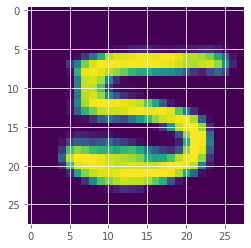

Train Epoch: 91 [8400/60000 (64%)]	 KLD Loss: 4.078067 	 NLL Loss: 66.228310


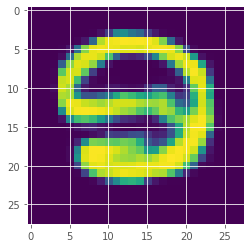

Train Epoch: 91 [11200/60000 (85%)]	 KLD Loss: 3.987683 	 NLL Loss: 67.177055


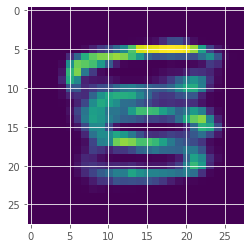

====> Epoch: 91 Average loss: 71.3529
====> Test set loss: KLD Loss = 4.2541, NLL Loss = 67.0165 
Saved model to saves/vrnn_state_dict_91.pth
Train Epoch: 92 [0/60000 (0%)]	 KLD Loss: 4.403417 	 NLL Loss: 68.864906


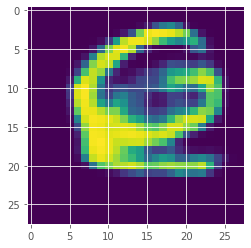

Train Epoch: 92 [2800/60000 (21%)]	 KLD Loss: 4.182525 	 NLL Loss: 67.361954


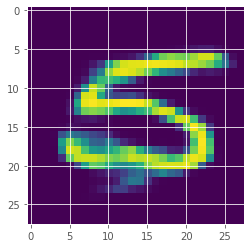

Train Epoch: 92 [5600/60000 (43%)]	 KLD Loss: 3.935433 	 NLL Loss: 65.020027


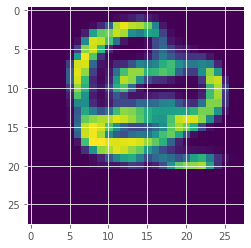

Train Epoch: 92 [8400/60000 (64%)]	 KLD Loss: 4.004182 	 NLL Loss: 67.315605


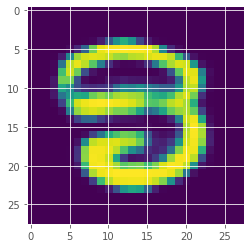

Train Epoch: 92 [11200/60000 (85%)]	 KLD Loss: 4.176041 	 NLL Loss: 68.029289


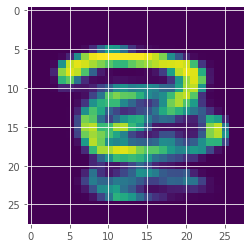

====> Epoch: 92 Average loss: 71.1731
====> Test set loss: KLD Loss = 4.2369, NLL Loss = 66.9156 
Train Epoch: 93 [0/60000 (0%)]	 KLD Loss: 4.577256 	 NLL Loss: 68.644287


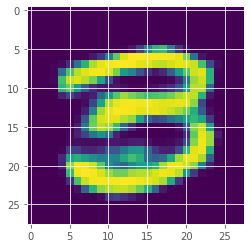

Train Epoch: 93 [2800/60000 (21%)]	 KLD Loss: 3.900512 	 NLL Loss: 66.753944


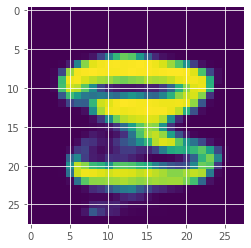

Train Epoch: 93 [5600/60000 (43%)]	 KLD Loss: 4.487658 	 NLL Loss: 68.620796


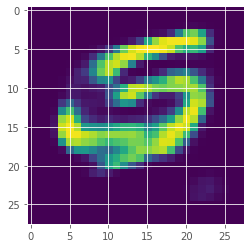

Train Epoch: 93 [8400/60000 (64%)]	 KLD Loss: 4.237621 	 NLL Loss: 70.364754


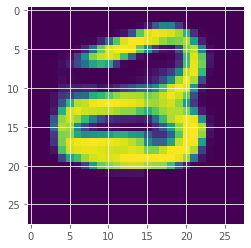

Train Epoch: 93 [11200/60000 (85%)]	 KLD Loss: 4.352655 	 NLL Loss: 68.575264


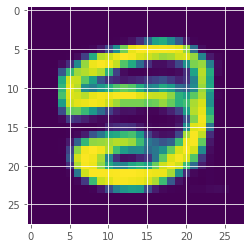

====> Epoch: 93 Average loss: 71.6765
====> Test set loss: KLD Loss = 4.1297, NLL Loss = 67.0529 
Train Epoch: 94 [0/60000 (0%)]	 KLD Loss: 4.302543 	 NLL Loss: 68.459747


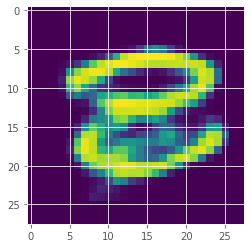

Train Epoch: 94 [2800/60000 (21%)]	 KLD Loss: 4.139234 	 NLL Loss: 69.576073


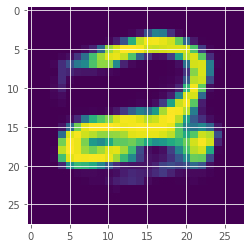

Train Epoch: 94 [5600/60000 (43%)]	 KLD Loss: 4.089556 	 NLL Loss: 66.043755


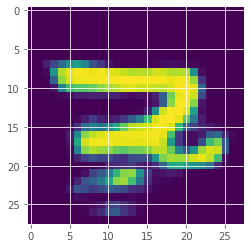

Train Epoch: 94 [8400/60000 (64%)]	 KLD Loss: 4.046236 	 NLL Loss: 64.714371


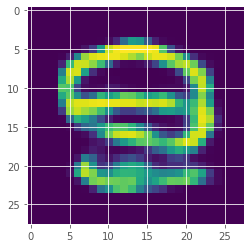

Train Epoch: 94 [11200/60000 (85%)]	 KLD Loss: 3.848532 	 NLL Loss: 69.117424


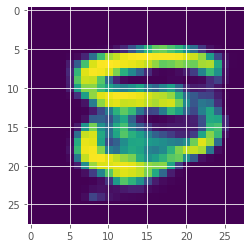

====> Epoch: 94 Average loss: 71.2395
====> Test set loss: KLD Loss = 4.3048, NLL Loss = 66.7397 
Train Epoch: 95 [0/60000 (0%)]	 KLD Loss: 4.156138 	 NLL Loss: 68.340439


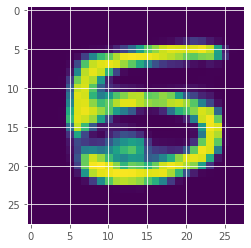

Train Epoch: 95 [2800/60000 (21%)]	 KLD Loss: 4.166902 	 NLL Loss: 66.053040


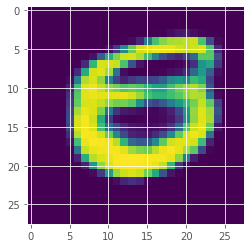

Train Epoch: 95 [5600/60000 (43%)]	 KLD Loss: 3.862573 	 NLL Loss: 67.281631


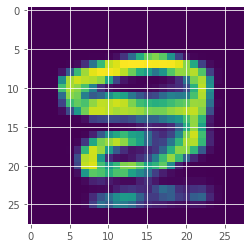

Train Epoch: 95 [8400/60000 (64%)]	 KLD Loss: 3.888622 	 NLL Loss: 67.225998


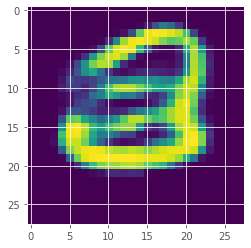

Train Epoch: 95 [11200/60000 (85%)]	 KLD Loss: 3.934646 	 NLL Loss: 67.643616


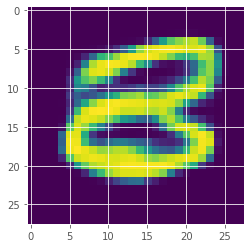

====> Epoch: 95 Average loss: 71.0634
====> Test set loss: KLD Loss = 4.1015, NLL Loss = 67.0157 
Train Epoch: 96 [0/60000 (0%)]	 KLD Loss: 3.993580 	 NLL Loss: 66.844398


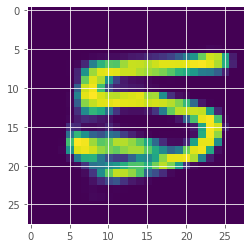

Train Epoch: 96 [2800/60000 (21%)]	 KLD Loss: 4.306156 	 NLL Loss: 67.319748


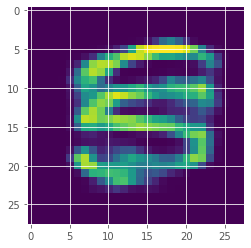

Train Epoch: 96 [5600/60000 (43%)]	 KLD Loss: 4.069113 	 NLL Loss: 63.888668


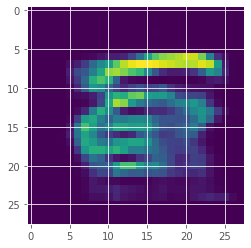

Train Epoch: 96 [8400/60000 (64%)]	 KLD Loss: 4.041023 	 NLL Loss: 66.463203


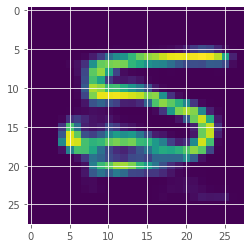

Train Epoch: 96 [11200/60000 (85%)]	 KLD Loss: 4.143129 	 NLL Loss: 69.663795


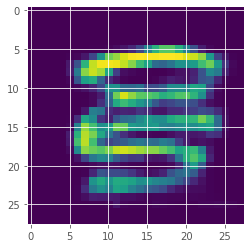

====> Epoch: 96 Average loss: 71.0646
====> Test set loss: KLD Loss = 4.1851, NLL Loss = 66.8537 
Train Epoch: 97 [0/60000 (0%)]	 KLD Loss: 4.007831 	 NLL Loss: 66.284607


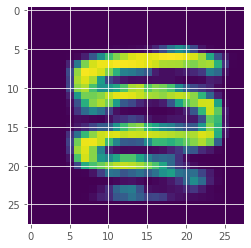

Train Epoch: 97 [2800/60000 (21%)]	 KLD Loss: 4.231715 	 NLL Loss: 67.037643


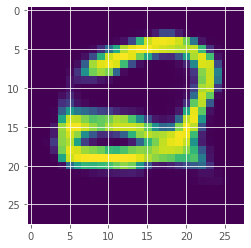

Train Epoch: 97 [5600/60000 (43%)]	 KLD Loss: 4.081854 	 NLL Loss: 67.222794


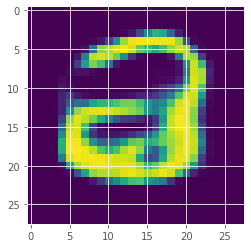

Train Epoch: 97 [8400/60000 (64%)]	 KLD Loss: 4.001632 	 NLL Loss: 66.564674


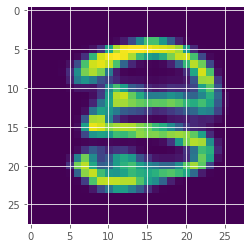

Train Epoch: 97 [11200/60000 (85%)]	 KLD Loss: 4.069015 	 NLL Loss: 65.872482


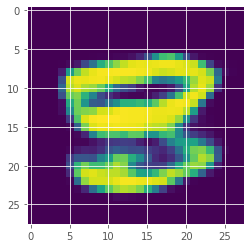

====> Epoch: 97 Average loss: 71.3386
====> Test set loss: KLD Loss = 4.1080, NLL Loss = 67.0859 
Train Epoch: 98 [0/60000 (0%)]	 KLD Loss: 4.055840 	 NLL Loss: 67.879837


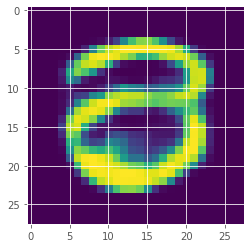

Train Epoch: 98 [2800/60000 (21%)]	 KLD Loss: 4.185492 	 NLL Loss: 66.093292


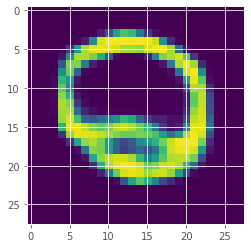

Train Epoch: 98 [5600/60000 (43%)]	 KLD Loss: 4.060343 	 NLL Loss: 66.182480


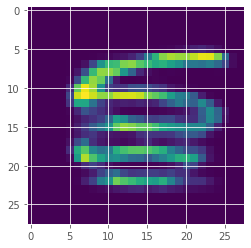

Train Epoch: 98 [8400/60000 (64%)]	 KLD Loss: 3.879943 	 NLL Loss: 67.026077


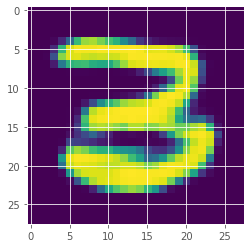

Train Epoch: 98 [11200/60000 (85%)]	 KLD Loss: 3.851495 	 NLL Loss: 67.022423


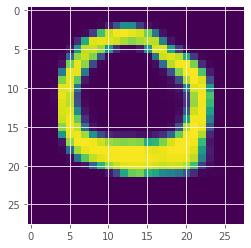

====> Epoch: 98 Average loss: 71.0364
====> Test set loss: KLD Loss = 4.1107, NLL Loss = 67.0257 
Train Epoch: 99 [0/60000 (0%)]	 KLD Loss: 4.102274 	 NLL Loss: 68.004936


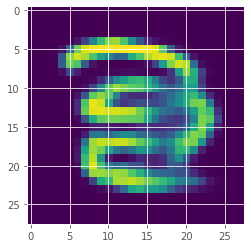

Train Epoch: 99 [2800/60000 (21%)]	 KLD Loss: 4.215321 	 NLL Loss: 67.805222


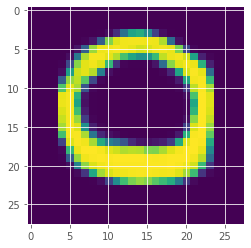

Train Epoch: 99 [5600/60000 (43%)]	 KLD Loss: 4.098763 	 NLL Loss: 65.716896


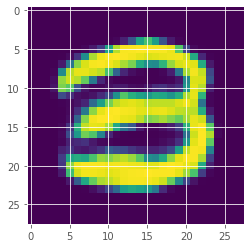

Train Epoch: 99 [8400/60000 (64%)]	 KLD Loss: 4.402096 	 NLL Loss: 69.098160


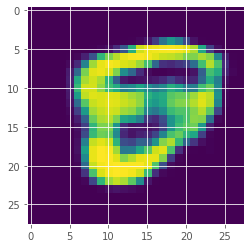

Train Epoch: 99 [11200/60000 (85%)]	 KLD Loss: 4.067763 	 NLL Loss: 66.848892


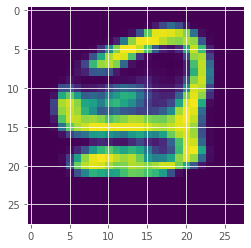

====> Epoch: 99 Average loss: 71.1437
====> Test set loss: KLD Loss = 4.2078, NLL Loss = 66.8641 
Train Epoch: 100 [0/60000 (0%)]	 KLD Loss: 4.412096 	 NLL Loss: 65.933197


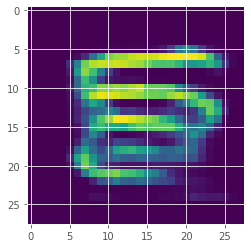

Train Epoch: 100 [2800/60000 (21%)]	 KLD Loss: 3.750099 	 NLL Loss: 61.189610


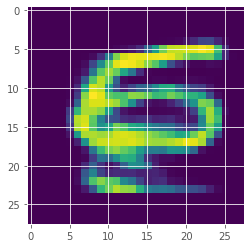

Train Epoch: 100 [5600/60000 (43%)]	 KLD Loss: 4.726750 	 NLL Loss: 70.773849


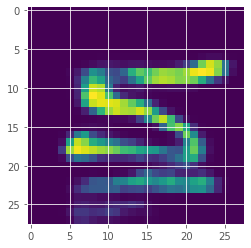

Train Epoch: 100 [8400/60000 (64%)]	 KLD Loss: 4.264062 	 NLL Loss: 70.242493


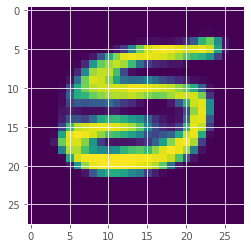

Train Epoch: 100 [11200/60000 (85%)]	 KLD Loss: 4.212543 	 NLL Loss: 69.903252


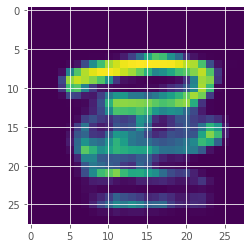

====> Epoch: 100 Average loss: 71.7131
====> Test set loss: KLD Loss = 4.3223, NLL Loss = 66.9318 


In [17]:
import math
import torch
import torch.nn as nn
import torch.utils
import torch.utils.data
from torchvision import datasets, transforms
from torch.autograd import Variable
import matplotlib.pyplot as plt 
#from model import VRNN

"""implementation of the Variational Recurrent
Neural Network (VRNN) from https://arxiv.org/abs/1506.02216
using unimodal isotropic gaussian distributions for 
inference, prior, and generating models."""


def train(epoch):
	train_loss = 0
	for batch_idx, (data, _) in enumerate(train_loader):
		
		#transforming data
		#data = Variable(data)
		#to remove eventually
		data = Variable(data.squeeze().transpose(0, 1))
		data = (data - data.min().item()) / (data.max().item() - data.min().item())
		
		#forward + backward + optimize
		optimizer.zero_grad()
		kld_loss, nll_loss, _, _ = model(data)
		loss = kld_loss + nll_loss
		loss.backward()
		optimizer.step()

		#grad norm clipping, only in pytorch version >= 1.10
		nn.utils.clip_grad_norm_(model.parameters(), clip)

		#printing
		if batch_idx % print_every == 0:
			print('Train Epoch: {} [{}/{} ({:.0f}%)]\t KLD Loss: {:.6f} \t NLL Loss: {:.6f}'.format(
				epoch, batch_idx * len(data), len(train_loader.dataset),
				100. * batch_idx / len(train_loader),
				kld_loss.item() / batch_size,
				nll_loss.item() / batch_size))

			sample = model.sample(28)
			plt.imshow(sample.numpy())
			plt.pause(1e-6)

		train_loss += loss.item()


	print('====> Epoch: {} Average loss: {:.4f}'.format(
		epoch, train_loss / len(train_loader.dataset)))
    
	return train_loss


def test(epoch):
	"""uses test data to evaluate 
	likelihood of the model"""
	
	test_loss = 0.
	mean_kld_loss, mean_nll_loss = 0, 0
	for i, (data, _) in enumerate(test_loader):                                            
		
		#data = Variable(data)
		data = Variable(data.squeeze().transpose(0, 1))
		data = (data - data.min().item()) / (data.max().item() - data.min().item())

		kld_loss, nll_loss, _, _ = model(data)
		loss = kld_loss + nll_loss
		mean_kld_loss += kld_loss.item()
		mean_nll_loss += nll_loss.item()
		test_loss += loss.item()

	mean_kld_loss /= len(test_loader.dataset)
	mean_nll_loss /= len(test_loader.dataset)
	test_loss /= len(test_loader.dataset)
	print('====> Test set loss: KLD Loss = {:.4f}, NLL Loss = {:.4f} '.format(
		mean_kld_loss, mean_nll_loss))
    
	return test_loss


#hyperparameters
x_dim = 28
h_dim = 100
z_dim = 16
n_layers =  1
n_epochs = 100
clip = 10
learning_rate = 1e-3
batch_size = 128
seed = 128
print_every = 100
save_every = 10

#manual seed
torch.manual_seed(seed)
plt.ion()

train_loss = []  # list of training losses for all epochs
test_loss = []   # list of test losses for all epochs

#init model + optimizer + datasets
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('data', train=True, download=True,
		transform=transforms.ToTensor()),
    batch_size=batch_size, shuffle=True)

test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('data', train=False, 
		transform=transforms.ToTensor()),
    batch_size=batch_size, shuffle=True)

model = VRNN(x_dim, h_dim, z_dim, n_layers)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

for epoch in range(1, n_epochs + 1):
	
	#training + testing
	train_loss_per_epoch = train(epoch)
	test_loss_per_epoch = test(epoch)
    
	train_loss.append(train_loss_per_epoch)
	test_loss.append(test_loss_per_epoch)

	#saving model
	if epoch % save_every == 1:
		fn = 'saves/vrnn_state_dict_'+str(epoch)+'.pth'
		torch.save(model.state_dict(), fn)
		print('Saved model to '+fn)

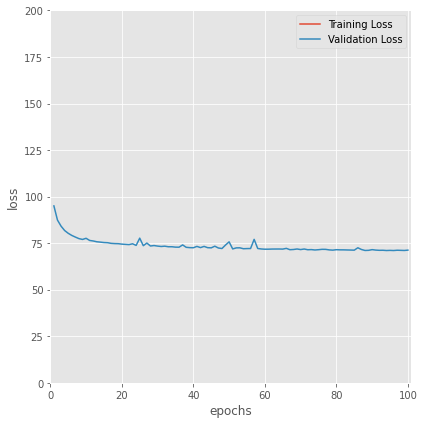

In [19]:
# visualize the loss as the network trained
fig = plt.figure(figsize=(6,6))
plt.plot(range(1,len(train_loss)+1),train_loss, label='Training Loss')
plt.plot(range(1,len(test_loss)+1),test_loss,label='Validation Loss')

# find position of lowest validation loss
#minposs = test_loss.index(min(test_loss))+1 
#plt.axvline(minposs, linestyle='--', color='r',label='Early Stopping Checkpoint')

plt.xlabel('epochs')
plt.ylabel('loss')
plt.ylim(0, 200) # consistent scale
plt.xlim(0, len(train_loss)+1) # consistent scale
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
fig.savefig('loss_plot.png', bbox_inches='tight')

In [4]:
set_all_seeds(123)

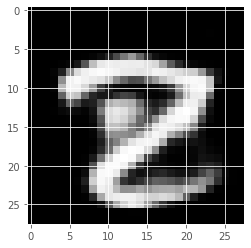

In [42]:
#hyperparameters
x_dim = 28
h_dim = 100
z_dim = 16
n_layers =  1

state_dict = torch.load('saves/vrnn_state_dict_41.pth')
model = VRNN(x_dim, h_dim, z_dim, n_layers)
model.load_state_dict(state_dict)

sample = model.sample(28)
plt.imshow(sample.numpy(), cmap='gray')
plt.show()

In [43]:
train_dataloader, test_dataloader = load_dataset(128)

In [44]:
dataiter = iter(train_dataloader)
images, labels = dataiter.next()
#print(images.size())  # ---> torch.Size([128, 1, 28, 28]) # batch_size number of images
#print(images[0].size()) # ---> torch.Size([1, 28, 28])     # images[0] is the image at index 0 in the given batch
#print(images[0].squeeze(0).size())  # ---> torch.Size([28, 28])

In [45]:
index = 112  # ranges from 0 to batch_size
x = images[index].squeeze(0)
print("This image is of digit: ",labels[index].numpy())

This image is of digit:  4


In [ ]:
def show(x):
    reconstructed_image = model.reconstruction_from_posterior(x)
    plt.imshow(reconstructed_image.cpu().detach().numpy())
    plt.show()
    
show(x)